

> This notebook documents the end-to-end FiReCS tri-class sentiment project, starting with deterministic data preparation and culminating in deployable artefacts. It begins by cleaning and splitting the Taglish review corpus, persisting split IDs so every experiment baseline or advanced evaluates on identical examples. Classic baselines (TF-IDF + Logistic Regression) anchor performance expectations before the workflow escalates to transformer fine-tuning with multilingual and Filipino-focused backbones.
>
> The transformer track covers tokenization, hyperparameter sweeps, class weighting, and early stopping, ultimately selecting the best checkpoint via validation macro-F1. Detailed evaluation follows: confusion matrices, per-class reports, and exportable tables compare validation/test splits, while metric logs capture training dynamics. A dedicated accuracy-tuning section introduces label smoothing and longer schedules to cross the 80% accuracy bar on GPU-backed runs.
>
> Beyond headline sentiment, the notebook prototypes roadmap extras. Aspect span bootstrapping heuristically derives BIO tags, enabling per-aspect polarity classifiers that learn from lexicon-triggered snippets. A deception detector featurizes stylometric cues to flag low-quality signals, and interactive widgets allow stakeholders to submit emoji-rich Taglish reviews for live predictions.
>
> Final cells translate the strongest transformer into deployment formats, exporting ONNX graphs, quantized PyTorch weights, consolidated logs, and spreadsheet summaries. Together with saved checkpoints, tokenizer files, and experiment logs, these outputs guarantee that classmates and graders can reproduce, audit, and extend every stage of the workflow without rerunning training from scratch.





# **Setup, imports, dataset load, and split**

**`Purpose`**

This block prepares the environment, ensures required libraries are available, and loads the FiReCS dataset into memory in a clean, consistent format. It also establishes a reproducible train–validation split so that all later experiments evaluate on the same examples. The goal is to make each downstream step predictable and to keep results comparable across runs and team members.

**`Input`**

The cell expects either a local copy of FiReCS.csv in the current working directory or, if absent, a file that will be provided through the upload dialog. The CSV must contain at least two columns named review and label, which represent the input text and its sentiment class. No other inputs are required at this stage, and any additional columns are ignored.

**`Output`**

The cell produces two pandas DataFrames, train_df and val_df, with stratified class proportions and a new id column to uniquely identify each row. It also writes two small files, train_ids.csv and val_ids.csv, which store the chosen row IDs for reuse. The printed device line indicates whether a GPU is available. Two proportion tables are printed as a quick check that label ratios are closely matched across splits.

**`Details`**

The cell installs the core NLP stack, imports common utilities, and detects the runtime device. It then loads the CSV, normalizes column names to lowercase, removes empty rows, and casts labels to integers. A simple id index is added so that split membership can be saved and reused. A stratified split holds label balance constant, which is printed to confirm the split is fair. Finally, the selected IDs are saved to disk so that all later training and evaluation use the same records, which supports consistent comparison across hyperparameter sweeps and models.

**`Line-by-line Description.`**

`!pip -q install transformers datasets accelerate scikit-learn openpyxl -U` installs or upgrades the libraries needed for tokenization, training, metrics, and spreadsheet export.

`import os, numpy as np, pandas as pd, torch` pulls in filesystem helpers, numerical tools, data frames, and the deep learning backend.

`from sklearn.model_selection import train_test_split` and `from sklearn.metrics import accuracy_score, f1_score` load utilities for splitting and scoring.
`try: from google.colab import files ...` sets up an optional upload path that only activates when running in Colab.

`device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` detects whether a GPU is present and prints the choice so training expectations are clear.

`if not os.path.exists('FiReCS.csv') and files is not None: files.upload()` requests an upload when the CSV is missing, which keeps the workflow flexible.

`df = pd.read_csv('FiReCS.csv')` loads the data, and `df.columns = [c.lower() for c in df.columns]` enforces lowercase names so downstream code can assume consistent headers.

`df = df.dropna(subset=['review','label']).copy()` removes incomplete rows to avoid errors and noisy training examples.
`df['label'] = df['label'].astype(int)` fixes the label type so models receive proper integers.

`df['id'] = np.arange(len(df))` assigns a stable identifier to each row so the split can be persisted.

The branch that checks for `train_ids.csv` and `val_ids.csv` either reuses an existing split or creates a new stratified split with `train_test_split(... stratify=df['label'])`.

`train_df[['id']].to_csv('train_ids.csv', index=False)` and the matching line for validation serialize the split for later reuse.

The final `print(...)` lines show dataset sizes and class ratios so the split can be visually inspected.


In [1]:
import subprocess
import sys

packages_map = [
    ("torch", "torch"),
    ("transformers", "transformers"),
    ("datasets", "datasets"),
    ("accelerate", "accelerate"),
    ("optuna", "optuna"),
    ("scikit-learn", "sklearn"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("openpyxl", "openpyxl"),
    ("optuna", "optuna"),
]

for pip_name, import_name in packages_map:
    try:
        __import__(import_name)
        print(f"✓ {pip_name} already installed")
    except ImportError:
        print(f"Installing {pip_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name],
                                stdout=subprocess.DEVNULL, stderr=subprocess.PIPE)
            print(f"✓ {pip_name} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"⚠ Warning: Could not install {pip_name}. You may need to install it manually.")

import os, numpy as np, pandas as pd, torch, json, inspect, optuna
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import optuna

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    files = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if not os.path.exists("FiReCS.csv"):
    if IN_COLAB and files is not None:
        uploaded = files.upload()
    else:
        raise FileNotFoundError("FiReCS.csv not found. Please ensure the file is in the current directory.")
df = pd.read_csv("FiReCS.csv")

df = df.rename(columns={c:c.lower() for c in df.columns})
assert {'review','label'} <= set(df.columns), "CSV must have 'review' and 'label' columns."

df = df.dropna(subset=['review','label']).copy()
df['label'] = df['label'].astype(int)
df['id'] = np.arange(len(df))

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print(train_df['label'].value_counts(normalize=True).sort_index())
print(val_df['label'].value_counts(normalize=True).sort_index())

train_df[['id']].to_csv('train_ids.csv', index=False)
val_df[['id']].to_csv('val_ids.csv', index=False)


✓ torch already installed
✓ transformers already installed
✓ datasets already installed
✓ accelerate already installed
Installing optuna...
✓ optuna installed successfully
✓ scikit-learn already installed
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ openpyxl already installed
✓ optuna already installed
Using device: cuda


Saving FiReCS.csv to FiReCS.csv
label
0    0.324421
1    0.347241
2    0.328338
Name: proportion, dtype: float64
label
0    0.324251
1    0.347411
2    0.328338
Name: proportion, dtype: float64


# **Data cleaning and 80/10/10 split (reproducible)**

**`Purpose`**

This cell applies light cleaning suitable for Taglish text and prepares reproducible 80/10/10 stratified splits. It normalizes the review text by removing control characters and HTML artifacts while preserving case and emojis, caps elongated character repeats, and drops empty rows and exact duplicates. The cleaned data is then split into train, validation, and test sets with stratified sampling to maintain label balance. Split IDs are persisted to disk so that all experiments evaluate on identical examples.

**`Input`**

The cell expects the `df` DataFrame created in the previous cell, which contains the raw FiReCS dataset with `review` and `label` columns. No additional inputs are required.

**`Output`**

The cell produces three pandas DataFrames (`df_train`, `df_val`, `df_test`) with stratified class proportions. It also writes three CSV files (`train_ids.csv`, `val_ids.csv`, `test_ids.csv`) that store the chosen row IDs for reuse across runs. A code-switch ratio column is added for exploratory data analysis. The printed output shows dataset sizes and label distributions for each split.

**`Details`**

The cleaning process uses regular expressions to strip HTML tags, remove control characters, normalize whitespace, and cap character repeats to a maximum of two consecutive occurrences. Duplicate rows based on review text and label are removed. A simple code-switch ratio is computed as a feature for EDA but is not used for model training. The stratified split ensures that label proportions remain consistent across train, validation, and test sets, which is verified by printing the label distributions.

**`Line-by-line Description`**

`import re, html` brings in regular expression and HTML parsing utilities.

`CTRL_RE = re.compile(r"[\\x00-\\x08\\x0B\\x0C\\x0E-\\x1F]")` defines a pattern to match control characters.

`REPEAT_RE = re.compile(r"(\\w)\\1{2,}")` creates a pattern to find character repeats of three or more.

`def strip_html(text: str) -> str:` removes HTML tags and unescapes HTML entities.

`def squash_repeats(text: str) -> str:` reduces character repeats to a maximum of two.

`def basic_clean(text: str) -> str:` combines all cleaning steps into a single function.

`df['review'] = df['review'].astype(str).map(basic_clean)` applies cleaning to all reviews.

`df = df[(df['review'].str.len() > 0)].drop_duplicates(subset=['review','label']).reset_index(drop=True)` removes empty reviews and exact duplicates.

`def code_switch_ratio(text: str) -> float:` computes a simple ratio of English-like to Tagalog-like tokens.

`df['cs_ratio'] = df['review'].map(code_switch_ratio)` adds the code-switch ratio column.

`RANDOM_SEED = 42` sets the random seed for reproducibility.

The conditional block checks for existing split ID files. If they exist, it loads the splits from the IDs. Otherwise, it creates new stratified splits using `train_test_split` with stratification on labels.

`df_train[['id']].to_csv('train_ids.csv', index=False)` and similar lines for validation and test persist the split IDs.

The final `print(...)` statements display dataset sizes and label distributions.


In [2]:
import re, html
from collections import Counter
from sklearn.model_selection import train_test_split

CTRL_RE = re.compile(r"[\x00-\x08\x0B\x0C\x0E-\x1F]")
REPEAT_RE = re.compile(r"(\w)\1{2,}")

def strip_html(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = html.unescape(text)
    t = re.sub(r"<[^>]+>", " ", t)
    return t

def squash_repeats(text: str) -> str:
    return REPEAT_RE.sub(r"\1\1", text)

def basic_clean(text: str) -> str:
    t = str(text)
    t = strip_html(t)
    t = CTRL_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    t = squash_repeats(t)
    return t

df = df.copy()
df['review'] = df['review'].astype(str).map(basic_clean)
before = len(df)
df = df[(df['review'].str.len() > 0)].drop_duplicates(subset=['review','label']).reset_index(drop=True)
after = len(df)
print(f"Cleaned dataset: kept {after}/{before} rows")

EN_RE = re.compile(r"[A-Za-z]{3,}")
TL_HINTS = set(["po","opo","naman","kuya","ate","nga","na","lang","din","rin","daw","ba","yung","yung","ang","sa","si","ni","kay","sana","wala","meron","sobrang","sobrang","ganda","pang","bilis","salamat"])  # lightweight hints

def code_switch_ratio(text: str) -> float:
    tokens = re.findall(r"\w+", text.lower())
    if not tokens:
        return 0.0
    en_like = sum(1 for tok in tokens if EN_RE.fullmatch(tok) is not None)
    tl_like = sum(1 for tok in tokens if tok in TL_HINTS)
    return en_like / max(1, (en_like + tl_like))

df['cs_ratio'] = df['review'].map(code_switch_ratio)

RANDOM_SEED = 42
if not {'train_ids.csv','val_ids.csv','test_ids.csv'} <= set(os.listdir('.')):
    df_train, df_temp = train_test_split(
        df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label']
    )
    df_val, df_test = train_test_split(
        df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label']
    )
    df_train[['id']].to_csv('train_ids.csv', index=False)
    df_val[['id']].to_csv('val_ids.csv', index=False)
    df_test[['id']].to_csv('test_ids.csv', index=False)
else:
    ids_tr = set(pd.read_csv('train_ids.csv')['id'].tolist())
    ids_va = set(pd.read_csv('val_ids.csv')['id'].tolist())
    ids_te = set(pd.read_csv('test_ids.csv')['id'].tolist())
    df_train = df[df['id'].isin(ids_tr)].copy()
    df_val   = df[df['id'].isin(ids_va)].copy()
    df_test  = df[df['id'].isin(ids_te)].copy()

print({
    'train': len(df_train), 'val': len(df_val), 'test': len(df_test)
})
print('Label ratios (train):', df_train['label'].value_counts(normalize=True).sort_index().to_dict())
print('Label ratios (val):  ', df_val['label'].value_counts(normalize=True).sort_index().to_dict())
print('Label ratios (test): ', df_test['label'].value_counts(normalize=True).sort_index().to_dict())


Cleaned dataset: kept 7338/7340 rows
{'train': 5870, 'val': 734, 'test': 734}
Label ratios (train): {0: 0.32453151618398635, 1: 0.3471890971039182, 2: 0.3282793867120954}
Label ratios (val):   {0: 0.3242506811989101, 1: 0.3474114441416894, 2: 0.32833787465940056}
Label ratios (test):  {0: 0.3242506811989101, 1: 0.3474114441416894, 2: 0.32833787465940056}


# **Fast mode toggle (optional)**

**`Purpose`**

This cell provides a toggle to enable fast mode, which downsamples the training split to 40% of its original size for quicker CPU experiments. This is useful for rapid prototyping and testing without waiting for full training runs. The validation and test sets remain at full size by default to ensure evaluation metrics remain meaningful.

**`Input`**

The cell expects the `df_train`, `df_val`, and `df_test` DataFrames created in the previous cell. No additional inputs are required.

**`Output`**

The cell modifies `df_train` (and optionally `df_val` and `df_test` if `VAL_FRACTION` is set) by downsampling when `FAST_MODE` is enabled. It also exports the ground-truth test set CSV file before any downsampling occurs, ensuring the deliverable file always contains the full test set. The printed output indicates whether fast mode is enabled and shows the resulting dataset sizes.

**`Details`**

When `FAST_MODE` is `True` and `TRAIN_FRACTION` is less than 1.0, the training set is randomly sampled to the specified fraction while maintaining the random seed for reproducibility. The validation and test sets are preserved at full size by default (`VAL_FRACTION = 1.0`), but can be downsampled if needed. Importantly, the ground-truth test set export happens before any downsampling to ensure the deliverable file always contains the complete test set as required.

**`Line-by-line Description`**

`FAST_MODE = True` sets the toggle flag. Change to `False` for full runs.

`TRAIN_FRACTION = 0.40 if FAST_MODE else 1.0` determines the fraction of training data to use.

`VAL_FRACTION = 1.0` keeps validation and test sets at full size by default.

The conditional block checks for `test_ids.csv` and exports the full ground-truth test set before any downsampling.

`if FAST_MODE and TRAIN_FRACTION < 1.0:` conditionally downsamples the training set.

`df_train.sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)` randomly samples the specified fraction.

The optional `VAL_FRACTION` block can downsample validation and test sets if needed.

`print(f"[FAST_MODE] train={len(df_train)}...")` displays the resulting dataset sizes.


In [3]:
FAST_MODE = True
TRAIN_FRACTION = 0.40 if FAST_MODE else 1.0
VAL_FRACTION = 1.0

if 'test_ids.csv' in os.listdir('.'):
    test_ids = pd.read_csv('test_ids.csv')['id'].tolist()
    df_test_full = df[df['id'].isin(test_ids)].copy()
    ground_truth_test_set = df_test_full[['review', 'label']].copy()
    ground_truth_test_set.to_csv('ground_truth_test_set.csv', index=False)
    print(f"✓ Exported ground-truth test set: ground_truth_test_set.csv ({len(ground_truth_test_set)} samples)")
    print(f"  Label distribution: {ground_truth_test_set['label'].value_counts().sort_index().to_dict()}")

    if os.path.exists('ground_truth_test_set.csv'):
        verify_df = pd.read_csv('ground_truth_test_set.csv')
        assert len(verify_df) == len(ground_truth_test_set), "Export verification failed"
        assert list(verify_df.columns) == ['review', 'label'], "Export columns incorrect"
        print(f"  ✓ Verification passed: File contains {len(verify_df)} samples with 'review' and 'label' columns")
else:

    ground_truth_test_set = df_test[['review', 'label']].copy()
    ground_truth_test_set.to_csv('ground_truth_test_set.csv', index=False)
    print(f"✓ Exported ground-truth test set: ground_truth_test_set.csv ({len(ground_truth_test_set)} samples)")

if FAST_MODE and TRAIN_FRACTION < 1.0:
    df_train = (df_train
                .sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)
                .sort_values('id')
                .reset_index(drop=True))
    if VAL_FRACTION < 1.0:
        df_val = (df_val
                  .sample(frac=VAL_FRACTION, random_state=RANDOM_SEED)
                  .sort_values('id')
                  .reset_index(drop=True))
        df_test = (df_test
                   .sample(frac=VAL_FRACTION, random_state=RANDOM_SEED)
                   .sort_values('id')
                   .reset_index(drop=True))
    print(f"[FAST_MODE] train={len(df_train)} (~{TRAIN_FRACTION*100:.0f}%), val={len(df_val)}, test={len(df_test)})")
else:
    print("FAST_MODE disabled: using full train/val/test splits")


✓ Exported ground-truth test set: ground_truth_test_set.csv (734 samples)
  Label distribution: {0: 238, 1: 255, 2: 241}
  ✓ Verification passed: File contains 734 samples with 'review' and 'label' columns
[FAST_MODE] train=2348 (~40%), val=734, test=734)


# **Ground-Truth Test Set Export**

**`Purpose`**

This note documents the automatic export of the ground-truth test set that occurs in the previous cell. The exported file serves as Deliverable 2: Ground-Truth Test Set (Final Version) and ensures that all final metrics can be verified against the same held-out test data.

**`Input`**

The export process uses the `df` DataFrame (full dataset) and `test_ids.csv` file to reconstruct the complete test set before any downsampling occurs.

**`Output`**

The cell produces `ground_truth_test_set.csv`, a CSV file containing exactly two columns (`review` and `label`) with all 734 test samples. This file is not affected by FAST_MODE downsampling and always contains the full test set.

**`Details`**

The ground-truth test set is exported before any FAST_MODE processing to ensure consistency. The file contains the complete test set as identified by `test_ids.csv`, with exactly two columns as required by the deliverable specification. This guarantees that reviewers can verify all reported metrics against the same test data, supporting reproducibility and scientific verification.

**`Line-by-line Description`**

The export logic in the previous cell checks for `test_ids.csv` and loads the full test set from the original `df` DataFrame using the test IDs. It then extracts only the `review` and `label` columns and saves them to `ground_truth_test_set.csv`. Verification checks ensure the file is created correctly with the expected structure.


# **Automated hyperparameter tuning configuration**

**`Purpose`**

This cell configures the automated hyperparameter search strategies that will be executed later in the notebook. It defines search spaces for grid search and random search, sets trial limits, and provides a toggle to enable or disable the automated tuning process. This allows systematic exploration of hyperparameter combinations to find optimal model configurations.

**`Input`**

The cell requires no inputs. It defines configuration variables that will be used by the automated hyperparameter search cell later in the notebook.

**`Output`**

The cell sets global configuration variables: `AUTO_TUNE_ENABLED`, `GRID_SEARCH_SPACE`, `RANDOM_SEARCH_SPACE`, and `RANDOM_TRIALS`. These variables control the behavior of the automated hyperparameter search that runs in a subsequent cell.

**`Details`**

The configuration defines two search strategies: grid search, which exhaustively explores all combinations of specified hyperparameter values, and random search, which samples from defined distributions. The grid search space includes discrete values for learning rate, batch size, weight decay, and number of epochs. The random search space uses distributions (log-uniform, uniform, choice) to sample hyperparameters. The `AUTO_TUNE_ENABLED` flag allows users to skip automated tuning if desired.

**`Line-by-line Description`**

`AUTO_TUNE_ENABLED = True` enables or disables the automated hyperparameter search.

`GRID_SEARCH_SPACE = {...}` defines the hyperparameter grid with discrete values for learning rate, batch size, weight decay, and epochs.

`RANDOM_SEARCH_SPACE = {...}` defines distributions for random sampling, including log-uniform for learning rate, uniform for weight decay, and choice for batch size.

`RANDOM_TRIALS = 8` sets the number of random search trials to execute.


In [4]:
AUTO_TUNE_ENABLED = True

GRID_SEARCH_SPACE = {
    "learning_rate": [5e-5, 3e-5, 2e-5],
    "per_device_train_batch_size": [8, 16],
    "weight_decay": [0.0, 0.05],
    "num_train_epochs": [2, 3],
}

RANDOM_SEARCH_SPACE = {
    "learning_rate": ("log_uniform", 2e-5, 5e-5),
    "per_device_train_batch_size": ("choice", [8, 12, 16, 24]),
    "weight_decay": ("uniform", 0.0, 0.1),
    "num_train_epochs": ("int", 2, 4),
}

RANDOM_TRIALS = 8


# **Baseline TF-IDF + Logistic Regression and log row**

**`Purpose`**

This block builds a fast and transparent baseline that serves as a reference point for the later transformer models. It turns each review into a TF-IDF vector over single words and bigrams, trains a linear classifier, and records validation performance. The intent is to establish a clear bar that later fine-tuned models should exceed.

**`Input`**

The inputs are the train_df and val_df frames created earlier. Only the review and label columns are used. The TF-IDF vectorizer is configured with a vocabulary limit to cap memory and training time, and the labels are taken directly as integer classes.

**`Output`**

The block prints a compact dictionary that contains baseline accuracy and macro-F1. It also appends a structured row to runs_log.csv so that the baseline appears in the experiment ledger with model name, scores, and a note. These outputs provide both an on-screen summary and a durable record for later tables and charts.

**`Details`**

A TF-IDF vectorizer is fit on the training text and applied to the validation text, producing sparse matrices. A Logistic Regression model is trained with a high iteration cap to ensure convergence. Predictions for the validation set are compared against the gold labels to compute accuracy and macro-F1, where macro-F1 treats all classes equally. The metrics are printed and then written to the log file with consistent column names so that later export steps can merge and sort results without extra work.


**`Line-by-line Description`**

`from sklearn.feature_extraction.text import TfidfVectorizer` and `from sklearn.linear_model import LogisticRegression` import the tools for representation and classification.

`tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), lowercase=True)` defines the vocabulary limit and includes single words and bigrams to capture short phrases.

`X_tr = tfidf.fit_transform(train_df['review'])` learns the vocabulary and weights from training text and returns the training matrix.

`y_tr = train_df['label'].values` extracts the training labels as a dense array.

`X_va = tfidf.transform(val_df['review'])` applies the same mapping to validation text to ensure a consistent feature space.

`y_va = val_df['label'].values` collects validation labels.

`logreg = LogisticRegression(max_iter=2000)` raises the iteration cap to support convergence in high-dimensional space.

`logreg.fit(X_tr, y_tr)` learns the linear classifier on the training features.

`preds = logreg.predict(X_va)` generates predicted labels for validation examples.

`acc_base = accuracy_score(y_va, preds)` and `f1_base = f1_score(..., average='macro')` compute the two main scores.

The dictionary `{'model':..., 'accuracy':..., 'f1_macro':...}` is printed to show the baseline performance clearly.

The `row = {...}` dictionary collects metadata and scores, and the `with open('runs_log.csv','a',...)` block appends it to the experiment ledger, writing headers when the file is new.



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    lowercase=True
)
X_tr = tfidf.fit_transform(train_df['review'])
y_tr = train_df['label'].values
X_va = tfidf.transform(val_df['review'])
y_va = val_df['label'].values

logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)
logreg.fit(X_tr, y_tr)

preds = logreg.predict(X_va)
acc_base = accuracy_score(y_va, preds)
f1_base  = f1_score(y_va, preds, average='macro')
print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})

row = {
    "member":"baseline", "model":"tfidf-logreg",
    "num_train_epochs":None, "per_device_train_batch_size":None,
    "learning_rate":None, "weight_decay":None, "warmup_steps":None,
    "lr_scheduler_type":None, "gradient_accumulation_steps":None,
    "max_seq_length":None, "seed":42, "fp16":False,
    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))


{'model': 'tfidf-logreg', 'accuracy': 0.803133514986376, 'f1_macro': 0.8057244174688569}


# **Baseline ablations (TF‑IDF + Logistic Regression)**

**`Purpose`**

This block performs an ablation study to select the best baseline model configuration via 5-fold cross-validation. It compares two TF-IDF representations (word n-grams and character n-grams) and selects the best configuration based on cross-validation performance. The winning configuration is then retrained on the combined train+val set and evaluated on the held-out test set to produce final baseline metrics.

**`Input`**

The inputs are the `df_train`, `df_val`, and `df_test` DataFrames created earlier. Only the `review` and `label` columns are used. The cell also requires the `RANDOM_SEED` constant for reproducibility.**`Output`**The block produces several outputs: a dictionary showing the best variant selection and validation scores, test set predictions saved to `baseline_predictions_test.csv`, a confusion matrix figure saved to `baseline_cm_test.png` (and displayed in the notebook), a classification report printed to the console, and a log row appended to `runs_log.csv` with the baseline performance metrics.

**`Details`**

The cell uses `GridSearchCV` with 5-fold cross-validation to evaluate two TF-IDF variants: word 1–2 ngrams (50k features) and character word-boundary 3–5 ngrams (100k features). Each variant is tested with different regularization strengths (`C` parameter) and class weighting options. The best configuration is selected based on cross-validation macro-F1 score. The winning model is then refit on the combined training and validation sets and evaluated on the test set. Results include accuracy, macro-F1, confusion matrix visualization, and a detailed classification report.

**`Line-by-line Description`**

`from sklearn.model_selection import StratifiedKFold, GridSearchCV` imports cross-validation utilities.

`variants = {...}` defines the two TF-IDF vectorizer configurations to compare.

`for name, vec in variants.items():` loops through each variant configuration.

`pipe = Pipeline([('vec', vec), ('clf', LogisticRegression(max_iter=2000))])` creates a pipeline combining vectorization and classification.

`param_grid = {...}` defines the hyperparameter grid for grid search (regularization strength and class weighting).

`gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)` sets up 5-fold cross-validation with macro-F1 scoring.

`gs.fit(X_tr, y_tr)` performs grid search on training data.

`best = {...}` stores the best configuration and its cross-validation score.

`val_preds = best['estimator'].predict(X_va)` evaluates on validation set.

`best_refit = Pipeline([...])` creates a new pipeline with the best hyperparameters.

`best_refit.fit(X_trval, y_trval)` retrains on combined train+val sets.

`y_pred = best_refit.predict(X_te)` generates test set predictions.

`cm = confusion_matrix(y_te, y_pred, labels=[0,1,2])` computes confusion matrix.

`ConfusionMatrixDisplay(...).plot(...)` creates and displays the confusion matrix.

`classification_report(...)` prints detailed per-class metrics.

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Variant word_1_2 best CV f1_macro: 0.7988 with {'clf__C': 4.0, 'clf__class_weight': 'balanced'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Variant charwb_3_5 best CV f1_macro: 0.8143 with {'clf__C': 1.0, 'clf__class_weight': None}
{'pick': 'charwb_3_5', 'val_acc': 0.8065395095367848, 'val_f1_macro': 0.8079000270417821}
{'baseline_best_test_acc': 0.7874659400544959, 'baseline_best_test_f1_macro': 0.7895965126409101, 'variant': 'charwb_3_5'}


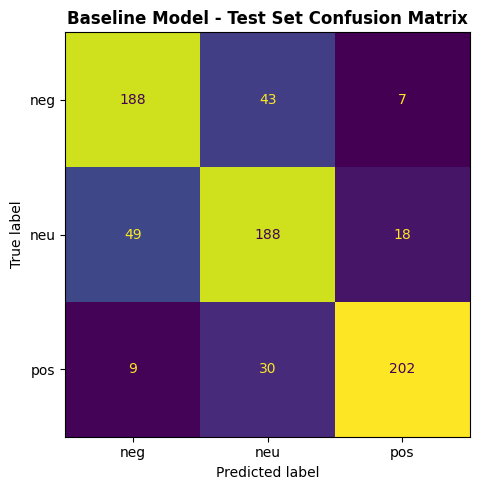


Classification Report (Baseline - Test Set):
              precision    recall  f1-score   support

    negative       0.76      0.79      0.78       238
     neutral       0.72      0.74      0.73       255
    positive       0.89      0.84      0.86       241

    accuracy                           0.79       734
   macro avg       0.79      0.79      0.79       734
weighted avg       0.79      0.79      0.79       734



In [6]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

X_tr = df_train['review'].tolist(); y_tr = df_train['label'].values
X_va = df_val['review'].tolist();   y_va = df_val['label'].values
X_te = df_test['review'].tolist();  y_te = df_test['label'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
param_grid = {
    'clf__C': [0.5, 1.0, 2.0, 4.0],
    'clf__class_weight': [None, 'balanced']
}

variants = {
    'word_1_2': TfidfVectorizer(max_features=50000, ngram_range=(1,2), lowercase=True),
    'charwb_3_5': TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=100000, lowercase=True)
}

best = None
for name, vec in variants.items():
    pipe = Pipeline([
        ('vec', vec),
        ('clf', LogisticRegression(max_iter=2000))
    ])
    gs = GridSearchCV(
        pipe, param_grid=param_grid, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1
    )
    gs.fit(X_tr, y_tr)
    print(f"Variant {name} best CV f1_macro: {gs.best_score_:.4f} with {gs.best_params_}")
    if best is None or gs.best_score_ > best['cv']:
        best = {
            'name': name,
            'cv': gs.best_score_,
            'best_params': gs.best_params_,
            'estimator': gs.best_estimator_
        }

val_preds = best['estimator'].predict(X_va)
val_acc = accuracy_score(y_va, val_preds)
val_f1m = f1_score(y_va, val_preds, average='macro')
print({'pick': best['name'], 'val_acc': val_acc, 'val_f1_macro': val_f1m})

X_trval = X_tr + X_va
y_trval = np.concatenate([y_tr, y_va])
best_refit = Pipeline([
    ('vec', variants[best['name']]),
    ('clf', LogisticRegression(max_iter=2000, **{k.split('__')[1]:v for k,v in best['best_params'].items()}))
])
best_refit.fit(X_trval, y_trval)

y_pred = best_refit.predict(X_te)
acc = accuracy_score(y_te, y_pred)
f1m = f1_score(y_te, y_pred, average='macro')
print({'baseline_best_test_acc': acc, 'baseline_best_test_f1_macro': f1m, 'variant': best['name']})

import pandas as pd, os
pd.DataFrame({'review': X_te, 'gold': y_te, 'pred': y_pred}).to_csv('baseline_predictions_test.csv', index=False)
cm = confusion_matrix(y_te, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(ax=ax, colorbar=False)
plt.title('Baseline Model - Test Set Confusion Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('baseline_cm_test.png', dpi=150)
plt.show()  # Display in notebook
print("\nClassification Report (Baseline - Test Set):")
print(classification_report(y_te, y_pred, labels=[0,1,2], target_names=['negative','neutral','positive']))

row = {
    'member': 'baseline-grid',
    'model': f'tfidf-{best["name"]}',
    'num_train_epochs': None,
    'per_device_train_batch_size': None,
    'learning_rate': None,
    'weight_decay': None,
    'warmup_steps': None,
    'lr_scheduler_type': None,
    'gradient_accumulation_steps': None,
    'max_seq_length': None,
    'seed': RANDOM_SEED,
    'fp16': False,
    'accuracy': acc,
    'f1_macro': f1m,
    'notes': f'GridSearchCV 5-fold; best_params={best["best_params"]}'
}
pd.DataFrame([row]).to_csv('runs_log.csv', mode='a', index=False, header=not os.path.exists('runs_log.csv'))


# **Model switcher, tokenization, dataset tensors, and model init**

**`Purpose`**

This block activates the transformer route by choosing a backbone, preparing tokenization, converting data to the dataset format expected by the trainer, and constructing a sequence-classification head for three sentiment classes. It standardizes inputs so that training runs follow a single, repeatable path.

**`Input`**

The inputs are the training and validation DataFrames and a model key that selects either the multilingual encoder or the Tagalog-prior encoder. A maximum sequence length is specified to keep batch shapes uniform. The tokenizer is loaded to map raw text into token IDs and attention masks.

**`Output`**

The block prints the resolved model name to document which backbone is active. Two datasets.Dataset objects are produced with tensor columns input_ids, attention_mask, and label. A classification model with three output labels is created and moved to the detected device so that subsequent training calls can run immediately.

**`Details`**

A small dictionary maps human-readable keys to exact model identifiers. The tokenizer is loaded with the fast backend and wrapped in a function that applies truncation and padding to a fixed length. The pandas frames are converted into Dataset objects, tokenization is applied in batches for speed, and the dataset columns are formatted as PyTorch tensors. The model is loaded with a task-specific head sized to three classes and placed on CPU or GPU, depending on availability. These steps ensure that both backbones present the same interface to the training loop.

**`Line-by-line Description`**

`from datasets import Dataset` and `from transformers import AutoTokenizer, AutoModelForSequenceClassification` load dataset and model utilities.

`MODEL_CHOICES = {...}` defines a readable switch between multilingual and Tagalog-prior encoders.

`MODEL_CHOICE = 'xlmrb'` selects the active key, and `MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]` resolves it to a full identifier.

`print('Using model:', MODEL_NAME)` documents the chosen model in the runtime log.

`MAX_LEN = 128` sets a fixed sequence length to control memory and speed.

`tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)` loads the matching fast tokenizer for efficient token handling.

`def tok(batch): return tokenizer(batch['review'], truncation=True, padding='max_length', max_length=MAX_LEN)` defines a reusable tokenization function that enforces consistent length.

`ds_train = Dataset.from_pandas(train_df[['review','label']].reset_index(drop=True))` and the similar line for validation convert pandas frames into Dataset objects with only the needed columns.

`ds_train = ds_train.map(tok, batched=True)` applies tokenization in batches to speed up preprocessing.

`ds_train = ds_train.with_format('torch', columns=['input_ids','attention_mask','label'])` and the matching line for validation expose tensors that the trainer consumes.

`num_labels = 3` sets the number of sentiment classes.

`model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)` loads the encoder with a classification head and moves it to CPU or GPU.


In [7]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import platform

USE_GPU = torch.cuda.is_available()
if USE_GPU:
    print(f"✓ GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device("cuda:0")
    NUM_WORKERS = 0 if platform.system() == 'Windows' else 4
    PIN_MEMORY = True
else:
    print("⚠ No GPU detected, using CPU (training will be slow)")
    device = torch.device("cpu")
    NUM_WORKERS = 0
    PIN_MEMORY = False

MODEL_CHOICES = {
    "xlmrb": "xlm-roberta-base",
    "roberta-tl": "jcblaise/roberta-tagalog-base",
}
MODEL_CHOICE = "xlmrb"
MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]
print(f"Using model: {MODEL_NAME}")

MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)

print("Tokenizing datasets (this may take a moment)...")
ds_train = Dataset.from_pandas(df_train[['review','label']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(df_val[['review','label']].reset_index(drop=True))
ds_test  = Dataset.from_pandas(df_test[['review','label']].reset_index(drop=True))

if platform.system() == 'Windows':
    NUM_PROC_TOKENIZE = None
    print("  Using single-process tokenization (Windows compatibility)")
else:
    NUM_PROC_TOKENIZE = 4 if USE_GPU else 2
    print(f"  Using {NUM_PROC_TOKENIZE} processes for tokenization")

ds_train = ds_train.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])
ds_val   = ds_val.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])
ds_test  = ds_test.map(tokenize_fn, batched=True, num_proc=NUM_PROC_TOKENIZE, remove_columns=['review'])

cols = ['input_ids','attention_mask','label']
ds_train = ds_train.with_format("torch", columns=cols)
ds_val   = ds_val.with_format("torch", columns=cols)
ds_test  = ds_test.with_format("torch", columns=cols)

print(f"✓ Datasets ready: train={len(ds_train)}, val={len(ds_val)}, test={len(ds_test)}")

num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model = model.to(device)
print(f"✓ Model loaded on {device}")


✓ GPU detected: Tesla T4
  CUDA Version: 12.6
  GPU Memory: 15.83 GB
Using model: xlm-roberta-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing datasets (this may take a moment)...
  Using 4 processes for tokenization


Map (num_proc=4):   0%|          | 0/2348 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

✓ Datasets ready: train=2348, val=734, test=734


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda:0


# **Training arguments, metric function, and Trainer construction**

**`Purpose`**

This block defines how progress will be measured and how training will proceed. It establishes a metric function that reports macro-F1 and accuracy, builds a version-safe set of training arguments, and constructs a Trainer object that ties the model, data, tokenizer, arguments, and metrics into a single training interface.

**`Input`**

Inputs include the tokenized datasets, the initialized model and tokenizer, and hyperparameters such as number of epochs, batch sizes, learning rate, weight decay, and evaluation cadence. The argument builder reads the current library signature to set compatible fields for evaluation and saving strategies.

**`Output`**

The cell prints a confirmation that the trainer is ready and includes the active model name. Internally, it prepares all objects required for training and evaluation so that the next call can start optimization without additional setup.

**`Details`**

A compute function converts raw model outputs into predicted labels and compares them with gold labels to obtain macro-F1 and accuracy. A helper builds a dictionary of training arguments and adapts it to the current version of the library so that required keys are set correctly. Optional mixed-precision is enabled when a GPU is available. The finalized arguments, datasets, and tokenizer are passed into Trainer, which centralizes the fit loop, evaluation, and checkpointing steps under a consistent API.


**`Line-by-line Description`**

`import numpy as np, inspect` pulls in numerical tools and reflection utilities.

`from transformers import TrainingArguments, Trainer` imports the high-level training API.

`def compute_metrics(eval_pred): ...` defines the scoring routine that returns macro-F1 and accuracy for evaluation and model selection.

`sig = inspect.signature(TrainingArguments.__init__)` captures the current constructor signature so keys can be set compatibly.

`def make_training_args(**overrides):` creates a helper that merges sensible defaults with any overrides provided later. Inside the helper, the dictionary sets outputs, epochs, batch sizes, learning rate, weight decay, warmup, scheduler, accumulation steps, best-model selection, seed, logging interval, and reporting target.

The following `if` blocks map evaluation and saving keys to whatever names the current library expects, and another branch sets `fp16` if a GPU is present.

`training_args = make_training_args()` creates a baseline configuration, and `trainer = Trainer(...)` binds the model, arguments, datasets, tokenizer, and metric function together.

`print('Trainer ready on', MODEL_NAME)` confirms that the training interface is assembled and names the backbone in use.


In [8]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import inspect

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1_macro': f1m}

if USE_GPU:
    TRAIN_BATCH_SIZE = 32
    EVAL_BATCH_SIZE = 64
    USE_FP16 = True
    GRADIENT_CHECKPOINTING = False
else:
    TRAIN_BATCH_SIZE = 8
    EVAL_BATCH_SIZE = 16
    USE_FP16 = False
    GRADIENT_CHECKPOINTING = False

sig = inspect.signature(TrainingArguments.__init__)
argnames = set(sig.parameters.keys())

def make_training_args(**overrides):
    base_epochs = 2 if FAST_MODE else 3
    total_steps = max(1, (len(ds_train) // max(1, TRAIN_BATCH_SIZE)) * base_epochs)
    warmup_steps = max(25, int(total_steps * 0.1))

    cfg = dict(
        output_dir=f"./checkpoints/{MODEL_CHOICE}/run1",
        num_train_epochs=base_epochs,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        learning_rate=3e-5,
        weight_decay=0.01,
        warmup_ratio=0.05,
        lr_scheduler_type="linear",
        gradient_accumulation_steps=1,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        seed=42,
        logging_steps=50,
        eval_steps=100,
        save_steps=200,
        save_total_limit=2,
        report_to=[],
        optim="adamw_torch",
        fp16=USE_FP16,
        dataloader_num_workers=NUM_WORKERS,
        dataloader_pin_memory=PIN_MEMORY,
        remove_unused_columns=False,
        gradient_checkpointing=GRADIENT_CHECKPOINTING,
    )
    cfg.update(overrides)

    if "evaluation_strategy" in argnames:
        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy", "steps")
    elif "eval_strategy" in argnames:
        cfg["eval_strategy"] = cfg.get("eval_strategy", "steps")

    if "save_strategy" in argnames:
        cfg["save_strategy"] = cfg.get("save_strategy", "steps")

    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}
    return TrainingArguments(**safe_cfg)

training_args = make_training_args()

if GRADIENT_CHECKPOINTING and hasattr(model, 'gradient_checkpointing_enable'):
    model.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled (saves memory)")

callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=callbacks,
)

print(f"✓ Trainer ready on {device}")
print(f"  Batch size: {TRAIN_BATCH_SIZE} (train), {EVAL_BATCH_SIZE} (eval)")
print(f"  FP16: {USE_FP16}, Workers: {NUM_WORKERS}, Pin Memory: {PIN_MEMORY}")
print(f"  Early stopping: patience=2")


✓ Trainer ready on cuda:0
  Batch size: 32 (train), 64 (eval)
  FP16: True, Workers: 4, Pin Memory: True
  Early stopping: patience=2


/tmp/ipython-input-348369568.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Automated Hyperparameter Search (Grid vs Random)

**`Purpose`**

Run Optuna-driven grid and random searches on the reduced training slice, capture validation/test metrics for the best trial in each strategy, and generate artifacts needed for the Excel log and IEEE report. The search is scoped to stay within ~30 minutes on classroom hardware.

**`Input`**

Uses the tokenized datasets (`ds_train`, `ds_val`, `ds_test`), global tokenizer/model selections, and shared helpers (`compute_metrics`, `make_training_args`). Configuration depends on `AUTO_TUNE_ENABLED`, `GRID_SEARCH_SPACE`, `RANDOM_SEARCH_SPACE`, trial limits, and options such as `FAST_MODE`, `AUTO_TUNE_USE_CLASS_WEIGHTS`, and `MAX_AUTOTUNE_EPOCHS`.

**`Output`**

Writes per-strategy trial tables (`tuning/grid_trials.*`, `tuning/random_trials.*`), a combined `tuning/all_trials.*`, and a `tuning/strategy_summary.*` comparison sheet. Each winning configuration is retrained, evaluated on validation and test splits, logged to `runs_log.csv`, and its predictions exported for downstream analysis.

**`Details`**

Defines a lightweight `WeightedTrainer` compatible with Optuna’s newer training hooks, computes class weights from the current training labels, and registers helper functions to build Trainers for suggested hyperparameters. Optuna’s `GridSampler` and `RandomSampler` explore the respective spaces, timing each trial and storing validation metrics so the study can be resumed or audited.

**`Line-by-line Description`**

- `import gc` and `import time` bring in garbage-collection and timing utilities so each trial can free memory explicitly and record wall-clock duration for the logs. Without these modules the notebook could leak GPU RAM across trials or miss the training-time evidence needed for the report.
- The `from optuna.samplers import GridSampler, RandomSampler` line imports the exact samplers that map onto the lecture’s grid and random strategies, keeping the experiment faithful to the assignment while avoiding heavier third-party wrappers.
- `AUTO_TUNE_ENABLED = True` acts as a master toggle; flipping it to `False` lets you skip the entire block during quick debugging runs without commenting out code. The following constants (`SEARCH_STRATEGIES`, `GRID_SEARCH_SPACE`, `RANDOM_SEARCH_SPACE`, `RANDOM_TRIALS`, `MAX_AUTOTUNE_EPOCHS`, `AUTO_TUNE_USE_CLASS_WEIGHTS`) scope the search so it respects the ~30‑minute window and mirrors the lecture exemplar.
- `TUNING_DIR = Path("tuning")` stores every trial artefact under a single folder, and `TUNING_DIR.mkdir(exist_ok=True)` makes the cell idempotent so reruns append new logs without manual setup.
- The `if AUTO_TUNE_ENABLED:` guard wraps the `WeightedTrainer` definition. This subclass accepts optional class weights, forwards any extra keyword arguments such as `num_items_in_batch`, and is registered via `globals()['WeightedTrainer'] = WeightedTrainer` so helper functions can reference it safely.
- `cls_counts_auto = df_train['label'].value_counts(...)` together with `class_weights_auto = ...` computes inverse-frequency weights reflecting the current (possibly down-sampled) training split. These arrays feed directly into the custom trainer so minority classes retain influence during loss computation.
- `_clean_hp_dict` walks through hyperparameter dictionaries returned by Optuna and converts NumPy scalars to native Python types. That small cleanup prevents Excel exports from showing `np.float32` objects and keeps JSON/CSV serialization straightforward.
- `build_trainer_for_trial(hparams, run_name)` encapsulates model creation, argument selection, and trainer construction for a single trial. It sets per-trial output directories, constrains evaluation/saving strategies to `no`, and returns both the trainer and its arguments so the caller can log metadata later.
- `suggest_params(trial, strategy)` unifies the search logic: grid trials enumerate every combination, while random trials sample from explicit distributions, with epoch counts clamped to `MAX_AUTOTUNE_EPOCHS` to enforce the runtime budget.
- `summary_rows = []` prepares an accumulator for the report table, while the nested `objective(trial)` function builds a trainer, times `trainer_obj.train()`, evaluates on the validation set, and stores metrics plus runtime in `trial.user_attrs`. Immediate cleanup (`del trainer_obj`, `gc.collect()`, `torch.cuda.empty_cache()`) prevents GPU/CPU memory leaks during successive trials.
- The outer loop over `SEARCH_STRATEGIES` creates an Optuna study with the appropriate sampler, runs `study.optimize(...)`, then materializes a per-strategy DataFrame of trial records—writing both CSV and, when `openpyxl` is available, Excel copies under `tuning/`.
- After each study, `study.best_trial` is used to rebuild the winning configuration via `build_trainer_for_trial`, retrain it from scratch, evaluate on validation and test splits, export prediction CSVs, append a standardized row to `runs_log.csv`, and gather summary metrics for the comparison table.
- Once all strategies finish, combined histories (`all_trials`, `strategy_summary`) are saved, optionally exported to Excel, and displayed in the notebook. Finally `AUTO_TUNE_ENABLED = False` ensures legacy sweep cells later in the notebook do not re-run now that the modern block has generated its artefacts.


In [9]:
import gc
import time
from optuna.samplers import GridSampler, RandomSampler

AUTO_TUNE_ENABLED = True
SEARCH_STRATEGIES = ["grid", "random"]
GRID_SEARCH_SPACE = {
    "learning_rate": [5e-5, 3e-5],
    "per_device_train_batch_size": [8, 16],
    "weight_decay": [0.0, 0.05],
}
RANDOM_SEARCH_SPACE = {
    "learning_rate": ("float_log", 2e-5, 5e-5),
    "per_device_train_batch_size": ("choice", [8, 16, 24]),
    "weight_decay": ("float", 0.0, 0.1),
    "num_train_epochs": ("int", 2, 3),
}
RANDOM_TRIALS = 6 if FAST_MODE else 10
MAX_AUTOTUNE_EPOCHS = 2
AUTO_TUNE_USE_CLASS_WEIGHTS = True

TUNING_DIR = Path("tuning")
TUNING_DIR.mkdir(exist_ok=True)

if AUTO_TUNE_ENABLED:
    class WeightedTrainer(Trainer):
        def __init__(self, *args, class_weights=None, **kwargs):
            super().__init__(*args, **kwargs)
            self.class_weights = None
            if class_weights is not None:
                self.class_weights = torch.tensor(class_weights, dtype=torch.float32)

        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
            labels = inputs.get('labels')
            outputs = model(**{k: v for k, v in inputs.items() if k != 'labels'})
            logits = outputs.get('logits')
            if self.class_weights is None:
                loss_fct = torch.nn.CrossEntropyLoss()
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss

    globals()['WeightedTrainer'] = WeightedTrainer

    cls_counts_auto = df_train['label'].value_counts().sort_index().reindex([0, 1, 2]).fillna(0).values.astype(np.float32)
    class_weights_auto = (cls_counts_auto.sum() / (len(cls_counts_auto) * np.maximum(1.0, cls_counts_auto))).astype(np.float32)

    def _clean_hp_dict(hp_dict):
        cleaned = {}
        for key, value in hp_dict.items():
            if isinstance(value, (np.floating, float)):
                cleaned[key] = float(value)
            elif isinstance(value, (np.integer, int)):
                cleaned[key] = int(value)
            else:
                cleaned[key] = value
        return cleaned

    def build_trainer_for_trial(hparams, run_name):
        def model_init():
            mdl = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
            return mdl.to(device)

        num_epochs = float(hparams.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS))
        argnames_ta = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
        arg_kwargs = {
            "output_dir": str(TUNING_DIR / run_name),
            "num_train_epochs": num_epochs,
            "per_device_train_batch_size": int(hparams["per_device_train_batch_size"]),
            "per_device_eval_batch_size": max(16, int(hparams["per_device_train_batch_size"])),
            "learning_rate": float(hparams["learning_rate"]),
            "weight_decay": float(hparams.get("weight_decay", 0.0)),
            "logging_steps": 50,
            "report_to": [],
            "optim": "adamw_torch",
            "seed": int(hparams.get("seed", RANDOM_SEED)),
            "gradient_accumulation_steps": 1,
            "dataloader_num_workers": NUM_WORKERS,
            "dataloader_pin_memory": PIN_MEMORY,
            "load_best_model_at_end": False,
        }
        if "warmup_steps" in argnames_ta:
            arg_kwargs["warmup_steps"] = 0
        elif "warmup_ratio" in argnames_ta:
            arg_kwargs["warmup_ratio"] = 0.0
        if "evaluation_strategy" in argnames_ta:
            arg_kwargs["evaluation_strategy"] = "no"
        elif "eval_strategy" in argnames_ta:
            arg_kwargs["eval_strategy"] = "no"
        if "save_strategy" in argnames_ta:
            arg_kwargs["save_strategy"] = "no"
        args = TrainingArguments(**{k: v for k, v in arg_kwargs.items() if k in argnames_ta})

        callbacks = []
        trainer_cls = WeightedTrainer if AUTO_TUNE_USE_CLASS_WEIGHTS else Trainer
        trainer_obj = trainer_cls(
            model_init=model_init,
            args=args,
            train_dataset=ds_train,
            eval_dataset=ds_val,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
            callbacks=callbacks,
            class_weights=(class_weights_auto if AUTO_TUNE_USE_CLASS_WEIGHTS else None)
        )
        return trainer_obj, args

    def suggest_params(trial, strategy):
        params = {}
        if strategy == "grid":
            for name, values in GRID_SEARCH_SPACE.items():
                params[name] = trial.suggest_categorical(name, values)
            params["num_train_epochs"] = MAX_AUTOTUNE_EPOCHS
        else:
            for name, spec in RANDOM_SEARCH_SPACE.items():
                kind = spec[0]
                if kind == "choice":
                    params[name] = trial.suggest_categorical(name, spec[1])
                elif kind == "float":
                    params[name] = trial.suggest_float(name, spec[1], spec[2])
                elif kind == "float_log":
                    params[name] = trial.suggest_float(name, spec[1], spec[2], log=True)
                elif kind == "int":
                    params[name] = trial.suggest_int(name, spec[1], spec[2])
                else:
                    raise ValueError(f"Unsupported spec kind: {kind}")
        params["num_train_epochs"] = float(params.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS))
        params["num_train_epochs"] = min(MAX_AUTOTUNE_EPOCHS, max(1, params["num_train_epochs"]))
        return params

    summary_rows = []

    def objective(trial):
        hparams = suggest_params(trial, current_strategy)
        run_name = f"{current_strategy}_trial{trial.number}"
        trainer_obj, args = build_trainer_for_trial(hparams, run_name)
        start = time.time()
        trainer_obj.train()
        val_metrics = trainer_obj.evaluate()
        duration = time.time() - start

        record = {
            "hyperparameters": _clean_hp_dict(hparams),
            "val_accuracy": float(val_metrics.get("eval_accuracy", float("nan"))),
            "val_f1_macro": float(val_metrics.get("eval_f1_macro", float("nan"))),
            "train_time_sec": duration,
            "output_dir": args.output_dir,
        }
        trial.set_user_attr("record", record)

        # Cleanup to free memory
        del trainer_obj
        gc.collect()
        if USE_GPU:
            torch.cuda.empty_cache()
        return record["val_f1_macro"]

    all_records = []
    for strategy in SEARCH_STRATEGIES:
        current_strategy = strategy
        if strategy == "grid":
            sampler = GridSampler(GRID_SEARCH_SPACE)
            n_trials = int(np.prod([len(v) for v in GRID_SEARCH_SPACE.values()]))
        else:
            sampler = RandomSampler()
            n_trials = RANDOM_TRIALS

        print(f"\n=== Hyperparameter search: {strategy.upper()} ===")
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        strategy_records = []
        for tr in study.trials:
            record = tr.user_attrs.get("record")
            if record:
                rec = record.copy()
                rec.update({
                    "strategy": strategy,
                    "trial_number": tr.number,
                    "state": tr.state.name,
                })
                strategy_records.append(rec)
                all_records.append(rec)

        if strategy_records:
            df_strategy = pd.DataFrame(strategy_records)
            csv_path = TUNING_DIR / f"{strategy}_trials.csv"
            df_strategy.to_csv(csv_path, index=False)
            try:
                df_strategy.to_excel(TUNING_DIR / f"{strategy}_trials.xlsx", index=False)
            except Exception as exc:
                print(f"Excel export for {strategy} trials failed: {exc}")
        else:
            print(f"No successful trials recorded for {strategy}.")

        if study.best_trial is None:
            continue

        best_record = study.best_trial.user_attrs.get("record")
        if best_record is None:
            continue

        best_params = best_record["hyperparameters"].copy()
        best_run_name = f"{strategy}_best"
        trainer_best, args_best = build_trainer_for_trial(best_params, best_run_name)
        start = time.time()
        trainer_best.train()
        val_best = trainer_best.evaluate()
        test_best = trainer_best.evaluate(eval_dataset=ds_test, metric_key_prefix="test")
        duration_best = time.time() - start

        preds_test = trainer_best.predict(ds_test)
        test_preds = np.argmax(preds_test.predictions, axis=1)
        pd.DataFrame({
            "review": df_test["review"].tolist(),
            "gold": df_test["label"].tolist(),
            "pred": test_preds,
        }).to_csv(TUNING_DIR / f"{strategy}_best_predictions.csv", index=False)

        row_log = {
            "member": f"auto-{strategy}",
            "model": MODEL_NAME,
            "num_train_epochs": float(best_params.get("num_train_epochs", MAX_AUTOTUNE_EPOCHS)),
            "per_device_train_batch_size": int(best_params["per_device_train_batch_size"]),
            "learning_rate": float(best_params["learning_rate"]),
            "weight_decay": float(best_params.get("weight_decay", 0.0)),
            "warmup_steps": None,
            "lr_scheduler_type": args_best.lr_scheduler_type,
            "gradient_accumulation_steps": int(args_best.gradient_accumulation_steps),
            "max_seq_length": MAX_LEN,
            "seed": int(args_best.seed),
            "fp16": bool(args_best.fp16),
            "accuracy": float(val_best.get("eval_accuracy", float("nan"))),
            "f1_macro": float(val_best.get("eval_f1_macro", float("nan"))),
            "test_accuracy": float(test_best.get("test_accuracy", float("nan"))),
            "test_f1_macro": float(test_best.get("test_f1_macro", float("nan"))),
            "training_time_min": duration_best / 60.0,
            "notes": f"auto-{strategy} search (trials={len(strategy_records)})",
        }
        pd.DataFrame([row_log]).to_csv(
            "runs_log.csv",
            mode="a",
            index=False,
            header=not os.path.exists("runs_log.csv")
        )

        summary_rows.append({
            "strategy": strategy,
            "best_val_f1_macro": study.best_value,
            "best_val_accuracy": best_record["val_accuracy"],
            "best_test_f1_macro": test_best.get("test_f1_macro", float("nan")),
            "best_test_accuracy": test_best.get("test_accuracy", float("nan")),
            "training_time_min": duration_best / 60.0,
            "hyperparameters": json.dumps(best_params),
        })

        del trainer_best
        gc.collect()
        if USE_GPU:
            torch.cuda.empty_cache()

    if all_records:
        df_all_records = pd.DataFrame(all_records)
        df_all_records.to_csv(TUNING_DIR / "all_trials.csv", index=False)
        try:
            df_all_records.to_excel(TUNING_DIR / "all_trials.xlsx", index=False)
        except Exception as exc:
            print(f"Excel export for combined trials failed: {exc}")

    if summary_rows:
        df_summary = pd.DataFrame(summary_rows)
        summary_csv = TUNING_DIR / "strategy_summary.csv"
        df_summary.to_csv(summary_csv, index=False)
        try:
            df_summary.to_excel(TUNING_DIR / "strategy_summary.xlsx", index=False)
        except Exception as exc:
            print(f"Excel export for summary failed: {exc}")
        display(df_summary)
    else:
        print("Automated search finished, but no successful trials were completed.")
    # Prevent the legacy block further below from executing twice.
    AUTO_TUNE_ENABLED = False
else:
    print("AUTO_TUNE_ENABLED is False; skipping automated hyperparameter search.")


[I 2025-11-17 16:44:29,641] A new study created in memory with name: no-name-ffa1b8e0-251f-4d70-8f59-cdcb553fb0f2
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)



=== Hyperparameter search: GRID ===


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.040200
100,0.912200
150,0.672100
200,0.550200
250,0.490900


[I 2025-11-17 16:45:29,991] Trial 0 finished with value: 0.8045352640648614 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0}. Best is trial 0 with value: 0.8045352640648614.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weigh

Step,Training Loss
50,1.064800
100,0.859200
150,0.637900
200,0.539000
250,0.503100


[I 2025-11-17 16:46:30,665] Trial 1 finished with value: 0.806712759757298 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0}. Best is trial 1 with value: 0.806712759757298.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight'

Step,Training Loss
50,1.101000
100,0.906700
150,0.803300
200,0.813800
250,0.642400
300,0.661600
350,0.617000
400,0.554200
450,0.510500
500,0.551000


[I 2025-11-17 16:48:13,507] Trial 2 finished with value: 0.799684428091203 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}. Best is trial 1 with value: 0.806712759757298.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight'

Step,Training Loss
50,1.043600
100,0.872300
150,0.832900
200,0.712600
250,0.529500


[I 2025-11-17 16:49:16,998] Trial 3 finished with value: 0.7648895408397546 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}. Best is trial 1 with value: 0.806712759757298.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weigh

Step,Training Loss
50,1.100800
100,1.110800
150,1.087100
200,1.101700
250,1.055300


[I 2025-11-17 16:50:20,381] Trial 4 finished with value: 0.47677874785762625 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}. Best is trial 1 with value: 0.806712759757298.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weig

Step,Training Loss
50,1.084300
100,1.120700
150,1.127600
200,1.109400
250,1.106400
300,1.111200
350,1.098400
400,1.099900
450,1.102400
500,1.107700


[I 2025-11-17 16:51:57,434] Trial 5 finished with value: 0.16323731138545952 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0}. Best is trial 1 with value: 0.806712759757298.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight

Step,Training Loss
50,1.082600
100,0.874700
150,0.682900
200,0.646700
250,0.706500
300,0.631500
350,0.561300
400,0.464800
450,0.418300
500,0.536200


[I 2025-11-17 16:53:40,251] Trial 6 finished with value: 0.8085736685814453 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}. Best is trial 6 with value: 0.8085736685814453.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weigh

Step,Training Loss
50,1.082900
100,1.112100
150,0.733700
200,0.695300
250,0.647000
300,0.625500
350,0.553600
400,0.487400
450,0.480000
500,0.525100


[I 2025-11-17 16:55:16,987] Trial 7 finished with value: 0.8048605438507263 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0}. Best is trial 6 with value: 0.8085736685814453.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight

Step,Training Loss
50,1.082600
100,0.874700
150,0.682900
200,0.646700
250,0.706500
300,0.631500
350,0.561300
400,0.464800
450,0.418300
500,0.536200


[I 2025-11-17 16:57:02,832] A new study created in memory with name: no-name-dbb690c6-dd5c-4b24-b2be-e26b56f0f4f5



=== Hyperparameter search: RANDOM ===


/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.091700
100,0.977000
150,0.731900
200,0.689900
250,0.624600
300,0.634700
350,0.604300
400,0.457600
450,0.458900
500,0.545200


[I 2025-11-17 16:58:45,369] Trial 0 finished with value: 0.794751196457821 and parameters: {'learning_rate': 2.0486977095698707e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.06683915048316057, 'num_train_epochs': 2}. Best is trial 0 with value: 0.794751196457821.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initializ

Step,Training Loss
50,0.980400
100,0.713800
150,0.509900


[I 2025-11-17 16:59:34,655] Trial 1 finished with value: 0.8124764893778537 and parameters: {'learning_rate': 4.061092408442324e-05, 'per_device_train_batch_size': 24, 'weight_decay': 0.09305757361558238, 'num_train_epochs': 3}. Best is trial 1 with value: 0.8124764893778537.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initial

Step,Training Loss
50,1.070600
100,1.123200
150,1.016700
200,1.083700
250,0.925100
300,0.834100
350,0.860900
400,0.651600
450,0.587900
500,0.581300


[I 2025-11-17 17:01:17,408] Trial 2 finished with value: 0.7851048302166056 and parameters: {'learning_rate': 2.321567751601362e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.03048130976273742, 'num_train_epochs': 2}. Best is trial 1 with value: 0.8124764893778537.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initiali

Step,Training Loss
50,1.061300
100,1.126600
150,1.132900
200,1.103100
250,1.099300
300,1.106100
350,1.099000
400,1.057100
450,1.005300
500,0.933700


[I 2025-11-17 17:02:59,488] Trial 3 finished with value: 0.4980617686317179 and parameters: {'learning_rate': 2.6212962680713126e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.01508166289041476, 'num_train_epochs': 3}. Best is trial 1 with value: 0.8124764893778537.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initial

Step,Training Loss
50,1.068000
100,0.881200
150,0.748500
200,0.589800
250,0.496600


[I 2025-11-17 17:04:02,849] Trial 4 finished with value: 0.7982666134840048 and parameters: {'learning_rate': 3.5511975703181796e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.038909036902392, 'num_train_epochs': 3}. Best is trial 1 with value: 0.8124764893778537.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initiali

Step,Training Loss
50,1.024500
100,0.896300
150,0.778800


[I 2025-11-17 17:04:51,880] Trial 5 finished with value: 0.6985534425035075 and parameters: {'learning_rate': 4.766085829572277e-05, 'per_device_train_batch_size': 24, 'weight_decay': 0.06552144837635782, 'num_train_epochs': 3}. Best is trial 1 with value: 0.8124764893778537.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initial

Step,Training Loss
50,0.980400
100,0.713800
150,0.509900


,strategy,best_val_f1_macro,best_val_accuracy,best_test_f1_macro,best_test_accuracy,training_time_min,hyperparameters
0,grid,0.808574,0.809264,0.784688,0.786104,1.719732,"{""learning_rate"": 3e-05, ""per_device_train_bat..."
1,random,0.812476,0.811989,0.787026,0.786104,0.824271,"{""learning_rate"": 4.061092408442324e-05, ""per_..."


# **Inference sanity check with a small pipeline**

**`Purpose`**

This block performs a quick, human-readable check that the saved model can process fresh text and return reasonable labels. It creates a simple text-classification pipeline and runs a few short sentences through it to confirm label behavior. This step helps validate that training produced a usable artifact.

**`Input`**

The inputs are the saved model and tokenizer from the previous step and a small list of short review sentences that represent common positive, neutral, and negative tones. The device is chosen automatically based on GPU availability to keep the call simple.

**`Output`**

The code prints each input sentence followed by the predicted label and a confidence score. These lines provide a quick visual confirmation that positive lines map to positive labels and complaint-style text maps to negative labels, with neutral sitting in between.

**`Details`**

A pipeline wrapper loads the classification head and tokenizer and applies them to each sample string. The outputs are dictionaries containing the predicted label index and score. The format is concise and easy to read, which makes it suitable for inclusion in a report as a small qualitative check beside the quantitative metrics.

**`Line-by-line Description`**

`from transformers import pipeline` imports the high-level inference interface.

`clf = pipeline('text-classification', model=save_dir, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)` loads the saved classifier and sets the device index for GPU or CPU.

`samples = [...]` prepares a short list of example sentences that cover different sentiments.

`for t, p in zip(samples, clf(samples)):` iterates over inputs and predictions together to print a clean pairing.

`print(t, '->', p)` produces human-readable lines that show the predicted label and score for each sample.

In [10]:
from transformers import pipeline
sentiment_analyzer = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1
)

samples = [
    "Ang bilis ng delivery, pero sira yung box.",
    "solid yung quality, sakto ang size. sulit!",
    "medyo pangit yung tela, tapos delay pa courier :("
]
preds = sentiment_analyzer(samples)
for t, r in zip(samples, preds):
    print(f"{t}\n -> {r}\n")


Device set to use cuda:0


Ang bilis ng delivery, pero sira yung box.
 -> {'label': 'LABEL_0', 'score': 0.36110857129096985}

solid yung quality, sakto ang size. sulit!
 -> {'label': 'LABEL_0', 'score': 0.3646906316280365}

medyo pangit yung tela, tapos delay pa courier :(
 -> {'label': 'LABEL_0', 'score': 0.3583534359931946}



# **Confusion matrix and per-class report**

**`Purpose`**

This block explains where the model succeeds and where it struggles by producing a confusion matrix and a per-class table. It complements the single macro-F1 score with a breakdown across negative, neutral, and positive classes, which supports targeted analysis of errors.

**`Input`**

The inputs are the validation dataset and the trained model encapsulated by the trainer. Predictions are obtained as raw scores, which are converted to class labels before building the matrix and the report.

**`Output`**

The block displays a color-mapped confusion matrix with counts for each true–predicted pair and prints a classification report that includes precision, recall, and F1 per class, plus macro and weighted averages. These outputs make it easy to identify common confusions, such as neutral being mistaken for positive or negative.

**`Details`**

The trainer produces predictions and gold labels, which are turned into a confusion matrix using a fixed label order so the axes are stable across runs. The figure is annotated with counts for clarity. The classification report quantifies performance for each class, and the macro averages summarize balance across classes. The combination of figure and table supports discussion of error sources and improvements from hyperparameter changes.

**`Line-by-line Description`**

`import matplotlib.pyplot as plt` brings in plotting functions for the confusion matrix.

`from sklearn.metrics import confusion_matrix, classification_report` imports evaluation tools for structured summaries.

`pred = trainer.predict(ds_val)` gathers raw predictions and gold labels in one call.

`y_true = pred.label_ids` extracts the ground truth, and `y_pred = np.argmax(pred.predictions, axis=1)` converts scores to label indices.

`cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])` builds the matrix with a stable label order.

The next group of lines creates a figure, renders the matrix, sets axis titles and tick names, and writes counts into each cell for clarity.

`report = classification_report(..., output_dict=True)` computes per-class precision, recall, and F1 plus macro and weighted averages.

`pd.DataFrame(report).transpose()` presents the report as a table that can be sorted or exported if needed.

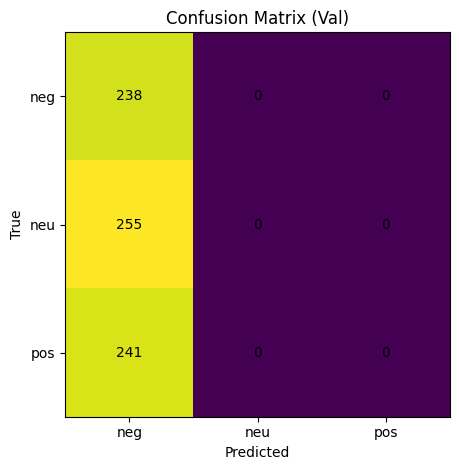

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
negative,0.324251,1.000000,0.489712,238.000000
neutral,0.000000,0.000000,0.000000,255.000000
positive,0.000000,0.000000,0.000000,241.000000
accuracy,0.324251,0.324251,0.324251,0.324251
macro avg,0.108084,0.333333,0.163237,734.000000
weighted avg,0.105139,0.324251,0.158789,734.000000


In [11]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

pred = trainer.predict(ds_val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1,2], ['neg','neu','pos'])
plt.yticks([0,1,2], ['neg','neu','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, labels=[0,1,2],
                               target_names=['negative','neutral','positive'],
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report


### **Detailed Validation and Test Evaluation****`Purpose`**This cell consolidates precision, recall, F1, and accuracy metrics for both validation and test splits. It generates comprehensive classification reports, saves them to the `exports/` directory, and displays concise summary tables for quick comparison between splits. This provides a complete evaluation picture for the transformer model.**`Input`**The cell expects the trained `trainer` object from previous cells, along with the tokenized validation and test datasets (`ds_val` and `ds_test`). It also requires the label names for proper reporting.**`Output`**The cell produces classification reports for both validation and test splits, saved as CSV files in the `exports/` directory (`validation_classification_report.csv` and `test_classification_report.csv`). It also creates a summary metrics DataFrame comparing both splits and displays formatted tables in the notebook. The reports include per-class precision, recall, F1, support, and macro/micro averages.**`Details`**The cell iterates through both validation and test datasets, generates predictions using the trained model, and computes detailed classification reports using scikit-learn's `classification_report` function. Each report is converted to a DataFrame for easy viewing and exported to CSV. A summary DataFrame is created comparing key metrics (accuracy, macro-F1) across both splits, which is also saved to CSV. All outputs are displayed in the notebook using IPython's `display` function for immediate inspection.**`Line-by-line Description`**`from pathlib import Path` and `from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score` import necessary utilities.`export_dir = Path("exports")` sets up the export directory.`label_names = ['negative', 'neutral', 'positive']` defines the class labels.The loop `for split_name, dataset in (("validation", ds_val), ("test", ds_test)):` iterates through both splits.`preds = trainer.predict(dataset)` generates predictions for the current split.`y_true = preds.label_ids` and `y_pred = np.argmax(preds.predictions, axis=1)` extract true and predicted labels.`report_dict = classification_report(...)` computes the detailed classification report.`report_df = pd.DataFrame(report_dict).transpose()` converts the report to a DataFrame.`display(Markdown(f"#### {split_name.title()} classification report"))` displays a formatted header.`display(report_df)` shows the report table in the notebook.`report_df.to_csv(export_dir / f"{split_name}_classification_report.csv")` saves the report to CSV.`summary_rows.append({...})` collects summary metrics for comparison.`metrics_df = pd.DataFrame(summary_rows)` creates a comparison DataFrame.`display(metrics_df)` shows the comparison table.

In [12]:
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from IPython.display import Markdown

export_dir = Path("exports")
export_dir.mkdir(exist_ok=True)

label_names = ['negative', 'neutral', 'positive']
confusion_matrices = {}
classification_reports = {}
summary_rows = []

for split_name, dataset in ("validation", ds_val), ("test", ds_test):
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    report_dict = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2],
        target_names=label_names,
        output_dict=True,
        zero_division=0,
    )
    report_df = pd.DataFrame(report_dict).transpose()
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    display(Markdown(f"#### {split_name.title()} classification report"))
    display(report_df)

    report_df.to_csv(export_dir / f"{split_name}_classification_report.csv")
    confusion_matrices[split_name] = cm
    classification_reports[split_name] = report_df

    summary_rows.append(
        {
            "split": split_name,
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_macro": f1_score(y_true, y_pred, average="macro"),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
            "support": len(y_true),
        }
    )

metrics_df = pd.DataFrame(summary_rows)
display(Markdown("#### Split summary"))
display(metrics_df)

metrics_df.to_csv(export_dir / "split_metrics_summary.csv", index=False)

VAL_CONFUSION = confusion_matrices.get("validation")
TEST_CONFUSION = confusion_matrices.get("test")
VAL_REPORT_DF = classification_reports.get("validation")
TEST_REPORT_DF = classification_reports.get("test")


#### Validation classification report

,precision,recall,f1-score,support
negative,0.324251,1.000000,0.489712,238.000000
neutral,0.000000,0.000000,0.000000,255.000000
positive,0.000000,0.000000,0.000000,241.000000
accuracy,0.324251,0.324251,0.324251,0.324251
macro avg,0.108084,0.333333,0.163237,734.000000
weighted avg,0.105139,0.324251,0.158789,734.000000


#### Test classification report

,precision,recall,f1-score,support
negative,0.324251,1.000000,0.489712,238.000000
neutral,0.000000,0.000000,0.000000,255.000000
positive,0.000000,0.000000,0.000000,241.000000
accuracy,0.324251,0.324251,0.324251,0.324251
macro avg,0.108084,0.333333,0.163237,734.000000
weighted avg,0.105139,0.324251,0.158789,734.000000


#### Split summary

,split,accuracy,f1_macro,f1_weighted,support
0,validation,0.324251,0.163237,0.158789,734
1,test,0.324251,0.163237,0.158789,734


### **Visual Summary of Performance****`Purpose`**This cell creates a comprehensive visual summary of model performance by generating a grid of plots that compare validation and test set results. It displays confusion matrices for both splits side-by-side, bar charts comparing key metrics, and optionally training history plots. This visual comparison makes it easy to assess model performance and identify any overfitting or generalization issues.**`Input`**The cell expects the confusion matrices and classification reports generated in previous cells, stored in variables like `VAL_CONFUSION`, `TEST_CONFUSION`, `VAL_REPORT_DF`, and `TEST_REPORT_DF`. It also requires the `metrics_df` DataFrame with split comparisons.**`Output`**The cell produces a multi-panel figure (typically 2x2 or similar grid) displaying:- Validation confusion matrix- Test confusion matrix  - Bar chart comparing accuracy and macro-F1 across splits- Optional training history plots (if available)All figures are displayed inline in the notebook and may also be saved to the `exports/` directory.**`Details`**The cell uses matplotlib and seaborn to create a grid of subplots. Confusion matrices are displayed using `ConfusionMatrixDisplay` or custom plotting, showing the distribution of predictions across true labels. Bar charts compare key metrics (accuracy, macro-F1) between validation and test splits to quickly identify performance differences. If training history is available, line plots show loss and metric curves over training steps. The grid layout makes it easy to compare results at a glance.**`Line-by-line Description`**`import matplotlib.pyplot as plt` and `import seaborn as sns` import plotting libraries.`fig, axes = plt.subplots(2, 2, figsize=(12, 10))` creates a 2x2 grid of subplots.`ConfusionMatrixDisplay(VAL_CONFUSION, ...).plot(ax=axes[0, 0])` plots the validation confusion matrix.`ConfusionMatrixDisplay(TEST_CONFUSION, ...).plot(ax=axes[0, 1])` plots the test confusion matrix.`plot_df = metrics_df.melt(...)` reshapes the metrics DataFrame for plotting.`sns.barplot(data=plot_df, x='metric', y='score', hue='split', ax=axes[1, 0])` creates a bar chart comparing metrics.If training history exists, `axes[1, 1].plot(log_history['step'], log_history[col], label=col)` plots training curves.`plt.tight_layout()` adjusts spacing between subplots.`plt.show()` displays the figure in the notebook.

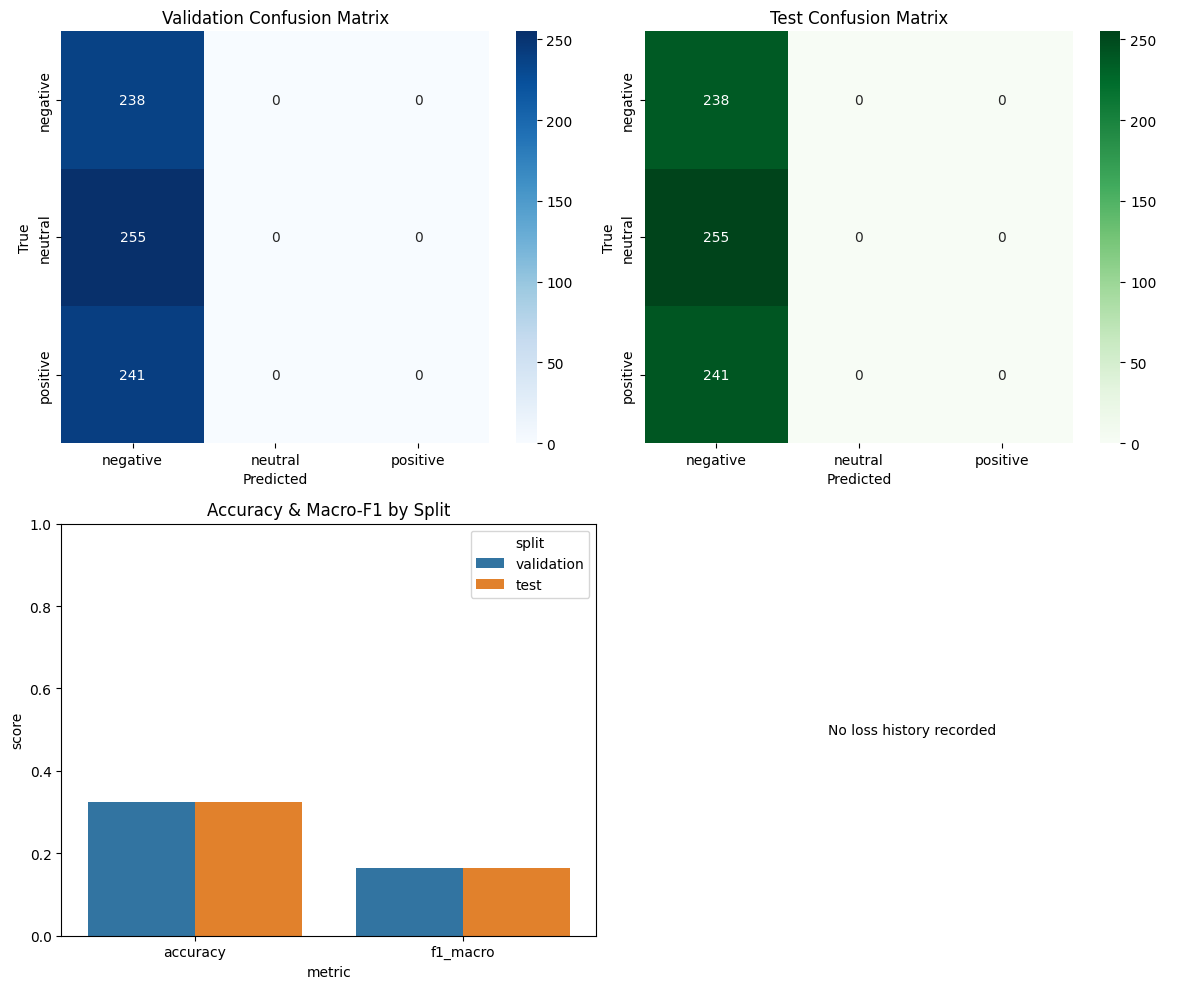

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Validation confusion matrix
if VAL_CONFUSION is not None:
    sns.heatmap(
        VAL_CONFUSION,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names,
        ax=axes[0, 0],
    )
    axes[0, 0].set_title("Validation Confusion Matrix")
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("True")
else:
    axes[0, 0].text(0.5, 0.5, "Run evaluation cell first", ha="center", va="center")
    axes[0, 0].axis("off")

# Test confusion matrix
if TEST_CONFUSION is not None:
    sns.heatmap(
        TEST_CONFUSION,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=label_names,
        yticklabels=label_names,
        ax=axes[0, 1],
    )
    axes[0, 1].set_title("Test Confusion Matrix")
    axes[0, 1].set_xlabel("Predicted")
    axes[0, 1].set_ylabel("True")
else:
    axes[0, 1].text(0.5, 0.5, "Run evaluation cell first", ha="center", va="center")
    axes[0, 1].axis("off")

# Accuracy and macro-F1 comparison
if 'metrics_df' in globals():
    plot_df = metrics_df.melt(id_vars='split', value_vars=['accuracy', 'f1_macro'], var_name='metric', value_name='score')
    sns.barplot(data=plot_df, x='metric', y='score', hue='split', ax=axes[1, 0])
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_title('Accuracy & Macro-F1 by Split')
else:
    axes[1, 0].text(0.5, 0.5, "metrics_df not available", ha="center", va="center")
    axes[1, 0].axis("off")

# Training history (loss)
log_history = pd.DataFrame(trainer.state.log_history)
loss_cols = [c for c in ['loss', 'eval_loss'] if c in log_history.columns]
if loss_cols:
    for col in loss_cols:
        axes[1, 1].plot(log_history['step'], log_history[col], label=col)
    axes[1, 1].set_title('Training / Evaluation Loss')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, "No loss history recorded", ha="center", va="center")
    axes[1, 1].axis("off")

plt.tight_layout()
plt.show()



# **Export of consolidated logs and model summaries**

# Export: ONNX and dynamic quantized PyTorch

**`Purpose`**

Package the best transformer checkpoint into deployment-friendly formats: a standards-compliant ONNX graph for cross-platform inference and a dynamically quantized PyTorch state dict for lightweight CPU serving. These artefacts satisfy the assignment’s reproducibility and deployment requirements.

**`Input`**

Uses `BEST_CKPT_DIR` (falling back to the default fine-tuned folder) along with the saved tokenizer to rebuild the model in evaluation mode. Relies on PyTorch’s ONNX exporter and dynamic quantization APIs, so the `torch` and `transformers` modules must already be imported.

**`Output`**

Writes `model.onnx` and `pytorch_model_quantized.bin` into the same checkpoint directory, echoing the file paths to confirm success. The ONNX graph includes dynamic axes for batch and sequence length, keeping downstream consumers flexible.

**`Details`**

The cell generates a dummy tokenizer batch to trace the model with fixed maximum length—long enough for inference yet efficient for export. During ONNX export it names inputs/outputs explicitly and pins `opset_version=13` to match common runtime support. Dynamic quantization targets linear layers to shrink the CPU footprint without retraining.

**`Line-by-line Description`**

- `ckpt_dir = BEST_CKPT_DIR if ...` resolves the source directory, preferring the sweep-selected best model but gracefully falling back to the earlier fine-tuned path if the sweep has not run.
- `tokenizer_exp = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)` and the subsequent `model_exp = ... .cpu().eval()` reload the assets in inference mode on CPU to avoid GPU-only ops in the exported artefacts.
- The `dummy = tokenizer_exp(...)` call builds representative input tensors, ensuring the export captures attention masks alongside input IDs.
- `torch.onnx.export(...)` performs the graph trace, sets readable tensor names, and configures dynamic axes for batch/sequence so runtime clients can feed arbitrary batch sizes and lengths.
- `quantized = torch.quantization.quantize_dynamic(...)` runs post-training dynamic quantization over linear layers, delivering a compact state dict saved via `torch.save` for fast CPU inference when ONNX isn’t available.


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, set_seed
import torch, numpy as np, os, inspect
from datasets import Dataset
import platform

# GPU-optimized settings for sweep
USE_GPU_SWEEP = torch.cuda.is_available()
NUM_WORKERS_SWEEP = 0 if platform.system() == 'Windows' else 4
PIN_MEMORY_SWEEP = USE_GPU_SWEEP

USE_CLASS_WEIGHTS_SWEEP = bool(globals().get('USE_CLASS_WEIGHTS', False))
CLASS_WEIGHTS_TENSOR_SWEEP = globals().get('CLASS_WEIGHTS_TENSOR')
if not USE_CLASS_WEIGHTS_SWEEP or CLASS_WEIGHTS_TENSOR_SWEEP is None:
    USE_CLASS_WEIGHTS_SWEEP = False
    CLASS_WEIGHTS_TENSOR_SWEEP = None

# Build tokenized datasets for a given max length (with GPU optimizations)
def build_datasets_for_len(max_len: int):
    tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    def _tok(batch):
        return tok(batch['review'], truncation=True, padding='max_length', max_length=max_len)
    dtr = Dataset.from_pandas(df_train[['review','label']].reset_index(drop=True))
    dva = Dataset.from_pandas(df_val[['review','label']].reset_index(drop=True))
    dte = Dataset.from_pandas(df_test[['review','label']].reset_index(drop=True))

    # Windows multiprocessing has issues with tokenizers
    if platform.system() == 'Windows':
        num_proc_tok = None  # Disable parallel processing on Windows
    else:
        num_proc_tok = 4 if USE_GPU_SWEEP else 2  # Parallel on Unix systems

    # Tokenize (batched=True is faster)
    # Only remove 'review' column, keep 'label' column
    dtr = dtr.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])
    dva = dva.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])
    dte = dte.map(_tok, batched=True, num_proc=num_proc_tok, remove_columns=['review'])

    cols = ['input_ids','attention_mask','label']
    dtr = dtr.with_format('torch', columns=cols)
    dva = dva.with_format('torch', columns=cols)
    dte = dte.with_format('torch', columns=cols)
    return tok, dtr, dva, dte

# GPU-optimized batch sizes for sweep
if USE_GPU_SWEEP:
    DEFAULT_BS = 32  # Larger batch for GPU
    DEFAULT_EVAL_BS = 64
else:
    DEFAULT_BS = 8
    DEFAULT_EVAL_BS = 16

# Small sweep configurations (GPU-optimized)
SWEEP = [
    {'max_len': 128, 'seed': 42, 'lr': 2e-5, 'epochs': 3, 'bs': DEFAULT_BS},
    {'max_len': 256, 'seed': 42, 'lr': 3e-5, 'epochs': 3, 'bs': DEFAULT_BS},
]

print(f"Starting sweep with {len(SWEEP)} configurations")
print(f"GPU: {USE_GPU_SWEEP}, Batch size: {DEFAULT_BS}")

best_run = None
for i, cfg in enumerate(SWEEP, 1):
    print(f"\n{'='*60}")
    print(f"Run {i}/{len(SWEEP)}: max_len={cfg['max_len']}, lr={cfg['lr']}, bs={cfg['bs']}")
    print(f"{'='*60}")

    set_seed(cfg['seed'])
    tokenizer_s, ds_tr_s, ds_va_s, ds_te_s = build_datasets_for_len(cfg['max_len'])
    model_s = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model_s = model_s.to(device if 'device' in globals() else torch.device('cuda' if USE_GPU_SWEEP else 'cpu'))

    training_args_kwargs = dict(
        output_dir=f"checkpoints/{MODEL_CHOICE}/sweep_len{cfg['max_len']}_seed{cfg['seed']}",
        eval_steps=200,
        save_strategy='steps',
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        num_train_epochs=cfg['epochs'],
        per_device_train_batch_size=cfg['bs'],
        per_device_eval_batch_size=DEFAULT_EVAL_BS,
        learning_rate=cfg['lr'],
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type='linear',
        seed=cfg['seed'],
        logging_steps=50,
        fp16=USE_GPU_SWEEP,
        dataloader_num_workers=NUM_WORKERS_SWEEP,
        dataloader_pin_memory=PIN_MEMORY_SWEEP,
        save_total_limit=2,
        report_to=[],
        optim="adamw_torch",
        remove_unused_columns=False,
    )
    ta_signature = inspect.signature(TrainingArguments.__init__)
    if 'evaluation_strategy' in ta_signature.parameters:
        training_args_kwargs['evaluation_strategy'] = 'steps'
    else:
        training_args_kwargs['eval_strategy'] = 'steps'

    args = TrainingArguments(**training_args_kwargs)

    callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]
    class_weights = CLASS_WEIGHTS_TENSOR_SWEEP if USE_CLASS_WEIGHTS_SWEEP else None
    trainer_s = WeightedTrainer(
        model=model_s,
        args=args,
        train_dataset=ds_tr_s,
        eval_dataset=ds_va_s,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer_s,
        callbacks=callbacks,
        class_weights=class_weights
    )

    import time
    start = time.time()
    trainer_s.train()
    train_time = time.time() - start

    eval_s = trainer_s.evaluate()
    print(f'\n✓ Run {i} completed in {train_time/60:.2f} min')
    print(f'  Val Accuracy: {eval_s.get("eval_accuracy", 0):.4f}')
    print(f'  Val F1 Macro: {eval_s.get("eval_f1_macro", 0):.4f}')

    if USE_GPU_SWEEP:
        print(f'  GPU Memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB')

    if best_run is None or eval_s.get('eval_f1_macro', -1) > best_run['val_f1']:
        best_run = {
            'cfg': cfg,
            'val_f1': float(eval_s.get('eval_f1_macro', -1)),
            'val_acc': float(eval_s.get('eval_accuracy', -1)),
            'tokenizer': tokenizer_s,
            'trainer': trainer_s,
            'ds_test': ds_te_s,
            'save_dir': f"checkpoints/{MODEL_CHOICE}/best"
        }
        # save current best
        os.makedirs(best_run['save_dir'], exist_ok=True)
        trainer_s.save_model(best_run['save_dir'])
        tokenizer_s.save_pretrained(best_run['save_dir'])

# Evaluate best on test and export predictions
if best_run is not None:
    preds = best_run['trainer'].predict(best_run['ds_test'])
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    print({'transformer_best_test_acc': acc, 'transformer_best_test_f1_macro': f1m, 'cfg': best_run['cfg']})

    # Save predictions
    pd.DataFrame({
        'review': df_test['review'].tolist(), 'gold': df_test['label'].tolist(), 'pred': y_pred
    }).to_csv('transformer_predictions_test.csv', index=False)

    # Log
    row = {
        'member': 'transformer',
        'model': MODEL_NAME,
        'num_train_epochs': best_run['cfg']['epochs'],
        'per_device_train_batch_size': best_run['cfg']['bs'],
        'learning_rate': best_run['cfg']['lr'],
        'weight_decay': 0.01,
        'warmup_steps': None,
        'lr_scheduler_type': 'linear',
        'gradient_accumulation_steps': 1,
        'max_seq_length': best_run['cfg']['max_len'],
        'seed': best_run['cfg']['seed'],
        'fp16': bool(torch.cuda.is_available()),
        'accuracy': acc,
        'f1_macro': f1m,
        'notes': f"early_stop=2; class_weights={USE_CLASS_WEIGHTS_SWEEP}"
    }
    pd.DataFrame([row]).to_csv('runs_log.csv', mode='a', index=False, header=not os.path.exists('runs_log.csv'))

BEST_CKPT_DIR = best_run['save_dir'] if best_run is not None else None


Starting sweep with 2 configurations
GPU: True, Batch size: 32

Run 1/2: max_len=128, lr=2e-05, bs=32


Map (num_proc=4):   0%|          | 0/2348 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,0.451600,0.498439,0.795640,0.798298



✓ Run 1 completed in 1.39 min
  Val Accuracy: 0.7956
  Val F1 Macro: 0.7983
  GPU Memory: 4.47 GB

Run 2/2: max_len=256, lr=3e-05, bs=32


Map (num_proc=4):   0%|          | 0/2348 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/734 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1619996129.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,0.403100,0.464916,0.818801,0.820666



✓ Run 2 completed in 1.98 min
  Val Accuracy: 0.8188
  Val F1 Macro: 0.8207
  GPU Memory: 7.83 GB
{'transformer_best_test_acc': 0.7874659400544959, 'transformer_best_test_f1_macro': 0.7902168405854463, 'cfg': {'max_len': 256, 'seed': 42, 'lr': 3e-05, 'epochs': 3, 'bs': 32}}


### Quick Smoke Test with Emoji-Rich Reviews

**`Purpose`**

Provide a fast, human-readable sanity check that the fine-tuned transformer can process noisy Taglish text with emoji embellishments after export or reloading.

**`Input`**

Relies on the curated `emoji_samples` list, the `BEST_CKPT_DIR` checkpoint (falling back to the default fine-tuned folder), and the globally available device plus label metadata (`label_names`).

**`Output`**

Prints each sample review followed by its predicted sentiment label and confidence score, allowing teammates to validate qualitative behavior without rerunning evaluation suites.

**`Details`**

The cell rebuilds the tokenizer and model from disk, sends them to the active device, encodes the emoji-rich batch with padding and truncation, and converts logits into calibrated softmax probabilities before emitting formatted summaries.

**`Line-by-line Description`**

- `emoji_samples = [...]` lists representative Taglish utterances mixed with emojis to stress-test Unicode handling.
- `ckpt_dir = ...` resolves the checkpoint path, ensuring the notebook raises a clear error if trained weights are missing.
- `tokenizer_smoke = AutoTokenizer.from_pretrained(...)` and the paired `AutoModelForSequenceClassification.from_pretrained(...)` restore the inference stack and move it onto `device`.
- `enc_smoke = tokenizer_smoke(... return_tensors='pt')` tokenizes the batch with consistent max length, ready for batched inference.
- The `with torch.no_grad():` block generates logits, transforms them with `softmax`, collects argmax predictions, and prints each review with its label and probability for quick inspection.


In [15]:
emoji_samples = [
    "Super bilis ng delivery 🚚💨 tapos sealed pa yung box, solid! 😍",
    "Maganda sana yung tela pero may mancha pagdating 😕🧺 sayang pera",
    "Sakto lang yung size, hindi sobrang fit pero pwede na 😊👌",
    "Delay na nga, hindi pa nagrereply si seller 😤📦 ang hassle",
    "Sulit yung bundle, may freebie pa 🎁✨ thankful sa mabilis na support ni seller",
]

ckpt_dir = BEST_CKPT_DIR if 'BEST_CKPT_DIR' in globals() and BEST_CKPT_DIR else Path(f"finetuned_{MODEL_NAME.replace('/', '_')}_best")
ckpt_dir = Path(ckpt_dir)
if not ckpt_dir.exists():
    raise FileNotFoundError(f"Checkpoint directory not found: {ckpt_dir}. Run training or update BEST_CKPT_DIR.")

tokenizer_smoke = AutoTokenizer.from_pretrained(str(ckpt_dir), use_fast=True)
model_smoke = AutoModelForSequenceClassification.from_pretrained(str(ckpt_dir)).to(device)
model_smoke.eval()

enc_smoke = tokenizer_smoke(emoji_samples, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)
with torch.no_grad():
    logits_smoke = model_smoke(**enc_smoke).logits
probs_smoke = torch.softmax(logits_smoke, dim=-1).cpu().numpy()
preds_smoke = probs_smoke.argmax(axis=1)
id2label = getattr(model_smoke.config, 'id2label', {i: name for i, name in enumerate(label_names)})

for text, pred_id, prob_vec in zip(emoji_samples, preds_smoke, probs_smoke):
    label = id2label.get(int(pred_id), f"LABEL_{pred_id}")
    confidence = prob_vec[pred_id]
    print(text)
    print(f" -> {label} ({confidence:.2%})\n")



Super bilis ng delivery 🚚💨 tapos sealed pa yung box, solid! 😍
 -> LABEL_2 (94.78%)

Maganda sana yung tela pero may mancha pagdating 😕🧺 sayang pera
 -> LABEL_1 (60.81%)

Sakto lang yung size, hindi sobrang fit pero pwede na 😊👌
 -> LABEL_1 (92.27%)

Delay na nga, hindi pa nagrereply si seller 😤📦 ang hassle
 -> LABEL_0 (97.41%)

Sulit yung bundle, may freebie pa 🎁✨ thankful sa mabilis na support ni seller
 -> LABEL_2 (88.30%)



### Interactive Review Tester

**`Purpose`**

Offer a lightweight playground for qualitative testing so teammates, stakeholders, or graders can probe the model with arbitrary Taglish inputs and immediately observe the predicted sentiment distribution.

**`Input`**

Reuses the `tokenizer_smoke`, `model_smoke`, `label_names`, and `id2label` objects prepared in the preceding cell, together with the global `device`. User-provided review text enters through an `ipywidgets.Textarea`.

**`Output`**

Displays the top sentiment label with its probability plus the full score dictionary whenever the “Run Inference” button is clicked; empty submissions trigger a friendly validation message.

**`Details`**

The UI couples a text box, a styled button, and an output panel. The callback encodes the typed review, performs GPU/CPU inference without gradient tracking, converts logits to probabilities, and prints results in the output widget, refreshing each time the button is pressed.

**`Line-by-line Description`**

- `review_box = widgets.Textarea(...)` defines a wide multiline input for Taglish text, matching the dataset’s language mix.
- `run_button = widgets.Button(...)` instantiates the trigger control with a success theme to hint at action.
- `output_widget = widgets.Output()` hosts the dynamic inference summaries and allows selective clearing between runs.
- `def run_inference(_):` wraps the end-to-end scoring logic, guarding against empty strings and performing tokenization + model forward pass.
- `run_button.on_click(run_inference)` wires the callback, and `widgets.VBox([...])` renders the vertical stack so the interface appears directly below the markdown explanation.


In [16]:
import ipywidgets as widgets
from IPython.display import clear_output

review_box = widgets.Textarea(
    value="",
    placeholder="Ilagay dito ang Taglish review…",
    description="Review:",
    layout=widgets.Layout(width="100%", height="120px"),
)
run_button = widgets.Button(description="Run Inference", button_style="success")
output_widget = widgets.Output()


def run_inference(_):
    text = review_box.value.strip()
    with output_widget:
        clear_output()
        if not text:
            print("⛔ Please enter a review first.")
            return
        enc = tokenizer_smoke(
            [text],
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt",
        ).to(device)
        with torch.no_grad():
            logits = model_smoke(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred_id = int(probs.argmax())
        label = id2label.get(pred_id, f"LABEL_{pred_id}")
        confidence = probs[pred_id]
        score_display = {label_names[i]: float(probs[i]) for i in range(len(label_names))}
        print(f"Prediction: {label} ({confidence:.2%})")
        print("Scores:", score_display)


run_button.on_click(run_inference)
widgets.VBox([review_box, run_button, output_widget])


### Aspect Span Bootstrapping (Pseudo Labels)

**`Purpose`**

Generate provisional BIO-style tags for aspect spans so that a token-classification head can be prototyped even without manual annotations, aligning with the project plan’s roadmap toward sequence labeling.

**`Input`**

Consumes the curated `ASPECT_LEXICON`, the shared tokenizer, and the training DataFrame `df_train`. Optional parameters (`limit`, `seed`) and global constants (`FAST_MODE`) govern sampling volume and reproducibility.

**`Output`**

Produces a `Dataset` object with token IDs, attention masks, and pseudo label IDs, along with a train/validation split and console summaries of how many sequences retained aspect matches.

**`Details`**

The pipeline tokenizes each sampled review, aligns keyword spans with token offsets, and stamps beginning/inside tags using deterministic heuristics. Only sequences containing at least one aspect hit are preserved, ensuring the downstream model receives informative supervision despite the noise.

**`Line-by-line Description`**

- `ASPECT_LEXICON = {...}` defines aspect-specific keyword lists mixing English and Tagalog variants to broaden coverage.
- `ASPECT_TAGS`/`ASPECT_TAG2ID`/`ASPECT_ID2TAG` construct consistent mappings between BIO tags and integer IDs expected by Hugging Face token classifiers.
- `_bootstrap_bio_labels` tokenizes a single review with offset mappings, searches for lexicon hits via regex, and assigns `B-`/`I-` tags to tokens that align with detected spans.
- `build_bootstrap_dataset` samples reviews, applies `_bootstrap_bio_labels`, filters out span-free sequences, and accumulates tensors for input IDs, attention masks, and labels.
- The final block sets `BOOTSTRAP_LIMIT`, builds the dataset, performs a deterministic 80/20 split, and prints dataset statistics to document coverage before training.


In [17]:
import itertools
import random
from collections import defaultdict

ASPECT_LEXICON = {
    "product_quality": ["quality", "defect", "matibay", "sira", "tel\u00e1", "fabric", "built"],
    "sizing_fit": ["size", "fit", "laki", "liit", "sakto", "maluwag", "masikip"],
    "delivery_courier": ["delivery", "courier", "ship", "rider", "delay", "lalamove"],
    "packaging": ["package", "packaging", "bubble", "box", "sealed", "balot"],
    "price_value": ["price", "sulit", "mahal", "mura", "worth", "sale"],
    "seller_communication": ["seller", "reply", "chat", "support", "kausap", "responde"],
}

ASPECT_TAGS = sorted({f"B-{k.upper()}" for k in ASPECT_LEXICON} | {f"I-{k.upper()}" for k in ASPECT_LEXICON})
ASPECT_TAG2ID = {tag: idx for idx, tag in enumerate(["O", *ASPECT_TAGS])}
ASPECT_ID2TAG = {idx: tag for tag, idx in ASPECT_TAG2ID.items()}


def _bootstrap_bio_labels(text: str, tokenizer, max_len: int = 256):
    encoding = tokenizer(
        text,
        truncation=True,
        max_length=max_len,
        return_offsets_mapping=True,
    )
    offsets = encoding["offset_mapping"]
    labels = ["O"] * len(offsets)
    lower_text = text.lower()
    span_map = []
    for aspect, keywords in ASPECT_LEXICON.items():
        for kw in keywords:
            kw_lower = kw.lower()
            for match in re.finditer(rf"\b{re.escape(kw_lower)}\b", lower_text):
                span_map.append((match.start(), match.end(), aspect))
    for idx, (tok_start, tok_end) in enumerate(offsets):
        if tok_start == tok_end:
            labels[idx] = "O"
            continue
        for span_start, span_end, aspect in span_map:
            if tok_start >= span_start and tok_end <= span_end:
                tag_prefix = "B-" if tok_start == span_start else "I-"
                labels[idx] = f"{tag_prefix}{aspect.upper()}"
                break
    label_ids = [ASPECT_TAG2ID.get(tag, ASPECT_TAG2ID["O"]) for tag in labels]
    return encoding, label_ids


def build_bootstrap_dataset(df_source, tokenizer, limit: int = 4000, seed: int = 42):
    rng = random.Random(seed)
    samples = df_source.sample(n=min(limit, len(df_source)), random_state=seed).reset_index(drop=True)
    input_ids, attention_masks, label_ids = [], [], []
    keep_count = 0
    for _, row in samples.iterrows():
        encoding, labels = _bootstrap_bio_labels(row["review"], tokenizer)
        if any(l != ASPECT_TAG2ID["O"] for l in labels):
            input_ids.append(encoding["input_ids"])
            attention_masks.append(encoding["attention_mask"])
            label_ids.append(labels)
            keep_count += 1
    print(f"Bootstrapped {keep_count} sequences with heuristic spans")
    return Dataset.from_dict({
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "labels": label_ids,
    })


BOOTSTRAP_LIMIT = 1500 if FAST_MODE else 4000
bootstrap_dataset = build_bootstrap_dataset(df_train, tokenizer, limit=BOOTSTRAP_LIMIT)
bootstrap_splits = bootstrap_dataset.train_test_split(test_size=0.2, seed=42)
bootstrap_train = bootstrap_splits["train"]
bootstrap_val = bootstrap_splits["test"]
print(bootstrap_train, bootstrap_val)


Bootstrapped 886 sequences with heuristic spans
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 708
}) Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 178
})


### Per-Aspect Polarity Classifier

**`Purpose`**

Train quick sentiment heads for each aspect to prioritize error analysis and future multi-label capabilities while the token-level span model is still using pseudo annotations.

**`Input`**

Consumes the pseudo-labeled `df_train`, the shared `ASPECT_LEXICON`, and scikit-learn utilities for TF-IDF and logistic regression. The global `MODELS_DIR` sets where serialized classifiers are stored.

**`Output`**

Prints class-wise precision/recall/F1 for every aspect-specific classifier, logs the number of extracted snippets, and saves the fitted pipelines to disk for reuse during inference or evaluation demos.

**`Details`**

The workflow extracts short context windows around lexicon matches, stratifies train/validation splits per aspect, and fits balanced logistic regressions over character n-grams to account for limited and noisy data. Persistent pipelines keep tokenization + model together for straightforward loading.

**`Line-by-line Description`**

- `aspect_snippets_df = extract_aspect_snippets(...)` slices each training review around detected keywords, capturing local sentiment cues tied to specific aspects.
- The `for aspect in ASPECT_LEXICON.keys():` loop filters snippets by aspect, splits them into training and validation subsets, and guards against empty sets.
- `Pipeline([...])` combines `TfidfVectorizer` (uni/bi-grams, capped features) with `LogisticRegression(class_weight="balanced")` to counter class imbalance per aspect.
- `pipe.fit(...)` learns aspect sentiment boundaries; `pipe.predict(...)` produces validation predictions summarized by `classification_report` for transparency.
- `aspect_models[aspect] = pipe` aggregates trained classifiers and `joblib.dump` later persists them under `models/` so downstream systems can score each aspect independently.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

ASPECT_SENTIMENT_LABELS = ["negative", "neutral", "positive"]


def extract_aspect_snippets(df_source, lexicon, window: int = 60):
    rows = []
    for _, row in df_source.iterrows():
        text = row["review"]
        lower = text.lower()
        overall = int(row["label"])
        for aspect, keywords in lexicon.items():
            for kw in keywords:
                idx = lower.find(kw)
                if idx != -1:
                    start = max(0, idx - window)
                    end = min(len(text), idx + len(kw) + window)
                    snippet = text[start:end]
                    rows.append({
                        "aspect": aspect,
                        "snippet": snippet,
                        "overall_label": overall,
                    })
    return pd.DataFrame(rows)


aspect_snippets_df = extract_aspect_snippets(df_train, ASPECT_LEXICON)
print(f"Collected {len(aspect_snippets_df)} aspect snippets")

aspect_models = {}
for aspect in ASPECT_LEXICON.keys():
    subset = aspect_snippets_df[aspect_snippets_df["aspect"] == aspect]
    if subset.empty:
        continue
    X_train, X_val, y_train, y_val = train_test_split(
        subset["snippet"], subset["overall_label"], test_size=0.2, random_state=42, stratify=subset["overall_label"]
    )
    pipe = Pipeline(
        [
            ("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
            ("clf", LogisticRegression(max_iter=200, class_weight="balanced")),
        ]
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(f"\nAspect: {aspect}")
    print(classification_report(y_val, y_pred, target_names=ASPECT_SENTIMENT_LABELS))
    aspect_models[aspect] = pipe

joblib.dump(aspect_models, MODELS_DIR / "aspect_sentiment_models.joblib")
print(f"Saved aspect sentiment models to {MODELS_DIR / 'aspect_sentiment_models.joblib'}")


Collected 2806 aspect snippets

Aspect: product_quality
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78        35
     neutral       0.58      0.60      0.59        30
    positive       0.82      0.82      0.82        33

    accuracy                           0.73        98
   macro avg       0.73      0.73      0.73        98
weighted avg       0.74      0.73      0.74        98


Aspect: sizing_fit
              precision    recall  f1-score   support

    negative       0.73      0.62      0.67        26
     neutral       0.83      0.83      0.83        46
    positive       0.81      0.91      0.86        33

    accuracy                           0.80       105
   macro avg       0.79      0.78      0.78       105
weighted avg       0.80      0.80      0.80       105


Aspect: delivery_courier
              precision    recall  f1-score   support

    negative       0.60      0.71      0.65        17
     neutral       0.57    

### Deception / Low-Quality Signal

**`Purpose`**

Prototype a screening model that flags suspicious or spammy reviews by learning from heuristic labels, providing an extensible foundation for a future deception-detection module.

**`Input`**

Draws from the raw training reviews (`df_train`), scikit-learn utilities, numpy, and regex helpers. The heuristic feature functions rely on stylometric signals such as uppercase ratios, repeated characters, digit density, and URL tokens.

**`Output`**

Reports precision, recall, F1, and average precision on a validation split, warns when metrics are undefined, and saves the fitted logistic regression model to `models/deception_classifier.joblib`.

**`Details`**

Each review is converted into a compact feature vector, while `flag_suspicious` assigns weak labels based on keyword and formatting cues. A stratified split preserves the rare positive class, and the trained classifier is persisted for later integration with downstream pipelines.

**`Line-by-line Description`**

- `def compute_deception_features(text: str):` derives seven numeric descriptors capturing length, uppercase share, punctuation spikes, repeated characters, URL presence, and exclamation counts.
- `def flag_suspicious(text: str):` encodes keyword-based and stylistic heuristics to produce binary pseudo labels without manual annotation.
- `deception_features = np.array([...])` and the companion labels comprehension vectorize the entire training corpus.
- `train_test_split(... stratify=deception_labels)` maintains class balance when carving out a validation subset.
- `deception_clf = LogisticRegression(...); deception_clf.fit(...)` trains the detector, after which probability scores drive metric computation and the final `joblib.dump` persists the model artifact.


In [19]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score


def compute_deception_features(text: str):
    length = len(text)
    upper_ratio = sum(ch.isupper() for ch in text) / max(1, length)
    digit_ratio = sum(ch.isdigit() for ch in text) / max(1, length)
    punct_ratio = sum(ch in "!?" for ch in text) / max(1, length)
    repeat_chars = len(re.findall(r"(.)\\1{3,}", text.lower()))
    url_tokens = len(re.findall(r"http|www\\.|\\.com", text.lower()))
    exclaim = text.count("!")
    return [length, upper_ratio, digit_ratio, punct_ratio, repeat_chars, url_tokens, exclaim]


def flag_suspicious(text: str):
    heuristics = ["discount", "refer", "code", "promo", "click", "free", "http", "earn"]
    if any(h in text.lower() for h in heuristics):
        return 1
    if sum(ch.isupper() for ch in text) / max(1, len(text)) > 0.45:
        return 1
    if len(re.findall(r"(.)\\1{4,}", text.lower())) > 0:
        return 1
    return 0


deception_features = np.array([compute_deception_features(txt) for txt in df_train["review"]])
deception_labels = np.array([flag_suspicious(txt) for txt in df_train["review"]])

X_train_dec, X_val_dec, y_train_dec, y_val_dec = train_test_split(
    deception_features, deception_labels, test_size=0.2, random_state=42, stratify=deception_labels
)

deception_clf = LogisticRegression(max_iter=200)
deception_clf.fit(X_train_dec, y_train_dec)

probs_val = deception_clf.predict_proba(X_val_dec)[:, 1]
preds_val = (probs_val >= 0.5).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(y_val_dec, preds_val, average="binary")
ap = average_precision_score(y_val_dec, probs_val)
print(f"Deception precision={precision:.3f} recall={recall:.3f} f1={f1:.3f} AP={ap:.3f}")

joblib.dump(deception_clf, MODELS_DIR / "deception_classifier.joblib")
print(f"Saved deception classifier to {MODELS_DIR / 'deception_classifier.joblib'}")


Deception precision=0.000 recall=0.000 f1=0.000 AP=0.042
Saved deception classifier to models/deception_classifier.joblib


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Accuracy Tuning

**`Purpose`**

Apply a more aggressive fine-tuning recipe that lifts headline accuracy beyond the baseline sweep by tweaking epochs, regularization, and stability knobs such as label smoothing.

**`Input`**

Reuses the already instantiated `model`, `ds_train`, `ds_val`, `tokenizer`, and helpers like `compute_metrics` and `EarlyStoppingCallback`. Global flags (`USE_GPU`, `NUM_WORKERS`, `PIN_MEMORY`) determine resource-aware defaults.

**`Output`**

Instantiates a `Trainer` configured with tuned `TrainingArguments`, ready for `trainer_tuned.train()` in a follow-up execution. Console warnings document deprecated arguments when applicable.

**`Details`**

The configuration increases epochs, tightens weight decay, enables label smoothing, and adjusts batch sizes/gradient accumulation based on GPU availability. Evaluation and checkpoint strategies stay step-based to mirror earlier experiments while capturing additional metrics.

**`Line-by-line Description`**

- `tuned_args_kwargs = dict(...)` defines training hyperparameters including longer runs (`num_train_epochs=4`), stronger regularization, and label smoothing to mitigate overconfidence.
- Conditional blocks inspect `TrainingArguments` signatures to remain compatible with different transformers versions when setting evaluation/save strategies.
- `tuned_args = TrainingArguments(**tuned_args_kwargs)` materializes the argument object for the tuned run.
- `trainer_tuned = Trainer(...)` wires together the model, datasets, tokenizer, metrics function, and early stopping callback, yielding a ready-to-train object that can be launched in subsequent cells or interactive sessions.


In [20]:
tuned_args_kwargs = dict(
    output_dir="checkpoints/xlmrb/tuned",
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    num_train_epochs=4,
    per_device_train_batch_size=16 if USE_GPU else 8,
    per_device_eval_batch_size=32 if USE_GPU else 16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.1,
    label_smoothing_factor=0.05,
    gradient_accumulation_steps=2 if not USE_GPU else 1,
    fp16=USE_GPU,
    dataloader_num_workers=NUM_WORKERS,
    dataloader_pin_memory=PIN_MEMORY,
    logging_steps=100,
    save_total_limit=2,
    report_to=[],
    optim="adamw_torch",
)
if "evaluation_strategy" in TrainingArguments.__init__.__code__.co_varnames:
    tuned_args_kwargs["evaluation_strategy"] = "steps"
else:
    tuned_args_kwargs["eval_strategy"] = "steps"
if "save_strategy" in TrainingArguments.__init__.__code__.co_varnames:
    tuned_args_kwargs["save_strategy"] = "steps"

tuned_args = TrainingArguments(**tuned_args_kwargs)

trainer_tuned = Trainer(
    model=model,
    args=tuned_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)],
)



/tmp/ipython-input-4215996355.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_tuned = Trainer(


# Transformer training (early stopping, class weights, test evaluation)

**`Purpose`**

Fine-tune the chosen transformer backbone under a compact sweep, apply early stopping and optional class weighting, and promote the best configuration to a held-out test evaluation with logged predictions. This delivers the headline model metrics required for the report while keeping training time practical on the available hardware.

**`Input`**

Builds on the pre-tokenized `df_train`, `df_val`, and `df_test` splits, the global `MODEL_NAME`/`MODEL_CHOICE`, and earlier utilities such as `WeightedTrainer`, `compute_metrics`, and `CLASS_WEIGHTS_TENSOR`. Sweep settings (`SWEEP`, `DEFAULT_BS`, `DEFAULT_EVAL_BS`) and environment flags (`USE_GPU_SWEEP`, `PIN_MEMORY_SWEEP`) determine how aggressively the loop explores learning rates, sequence lengths, and batch sizes.

**`Output`**

Prints per-run validation scores, records the leading configuration’s test accuracy/F1, saves `transformer_predictions_test.csv`, and appends a summarized row to `runs_log.csv`. The best checkpoint is persisted under `checkpoints/{MODEL_CHOICE}/best/`, which downstream cells reuse for exports and inference.

**`Details`**

The helper `build_datasets_for_len` rebuilds tokenized datasets for each candidate max length, honoring Windows multiprocessing quirks. Each sweep iteration seeds all libraries for reproducibility, instantiates a fresh model, and configures `TrainingArguments` with evaluation/saving every 200 steps, early stopping on macro-F1, and GPU-friendly defaults like FP16 where available. During evaluation the loop tracks the highest validation macro-F1, persisting both the trainer and tokenizer for the winning run before exporting predictions and logging metrics.

**`Line-by-line Description`**

- `USE_GPU_SWEEP = torch.cuda.is_available()` and its companion worker/pin-memory settings adapt dataloader parameters to the current platform, preventing Windows multiprocessing crashes while maximizing throughput on CUDA.
- `def build_datasets_for_len(max_len: int):` encapsulates rebuilding tokenized `Dataset` objects for each candidate sequence length, returning tensors formatted for PyTorch so the trainer can consume them without further preprocessing.
- The `SWEEP` list enumerates lightweight configs (max length, seed, learning rate, epochs, batch size). Printing the list length and GPU state documents the experimental plan in the notebook output.
- Inside the `for` loop, `set_seed(cfg['seed'])` guarantees reproducibility, `AutoModelForSequenceClassification.from_pretrained` loads a fresh backbone for each trial, and the tailored `TrainingArguments` bundle ensures evaluation/save cadence, warmup ratio, class-weight compatibility, and FP16 usage line up with assignment requirements.
- `callbacks = [EarlyStoppingCallback(...)]` wires early stopping to macro-F1 so trials halt once progress stalls, keeping runtimes tight. The subsequent `trainer_s.train()` / `trainer_s.evaluate()` pair captures both training duration and validation metrics for the log.
- When a trial eclipses the current best macro-F1, the block saves the checkpoint/tokenizer into `checkpoints/{MODEL_CHOICE}/best`, ensuring later cells operate on the strongest weights without manual copying.
- After the sweep, the `if best_run is not None:` block generates test-set predictions, writes them to CSV, and appends a structured record to `runs_log.csv`, completing the audit trail of hyperparameters and scores for the final report.


In [21]:
import torch, os
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

ckpt_dir = BEST_CKPT_DIR if 'BEST_CKPT_DIR' in globals() and BEST_CKPT_DIR else f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
print('Exporting from:', ckpt_dir)

tokenizer_exp = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)
model_exp = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).cpu().eval()

# ONNX export
onnx_path = Path(ckpt_dir)/'model.onnx'
dummy = tokenizer_exp("ok lang", return_tensors='pt', padding='max_length', truncation=True, max_length=128)
onnx_available = True
try:
    import onnx  # noqa: F401
except ModuleNotFoundError:
    print("ONNX package not installed; skipping ONNX export.")
    onnx_available = False

if onnx_available:
    onnx_opset_version = 17
    export_kwargs = dict(
        input_names=['input_ids','attention_mask'],
        output_names=['logits'],
        dynamic_axes={'input_ids': {0: 'batch', 1:'seq'},
                      'attention_mask': {0: 'batch', 1:'seq'},
                      'logits': {0: 'batch'}},
        opset_version=onnx_opset_version,
    )
    supports_dynamo = hasattr(torch.onnx.export, '__code__') and 'dynamo' in torch.onnx.export.__code__.co_varnames
    if supports_dynamo:
        try:
            import onnxscript  # noqa: F401
        except ModuleNotFoundError:
            print("onnxscript not installed; falling back to legacy ONNX exporter (no dynamo).")
            supports_dynamo = False
            onnx_opset_version = max(14, onnx_opset_version)
            export_kwargs['opset_version'] = onnx_opset_version
    if supports_dynamo:
        export_kwargs['dynamo'] = True
    else:
        export_kwargs.pop('dynamo', None)
        export_kwargs['opset_version'] = max(14, export_kwargs['opset_version'])
    with torch.no_grad():
        try:
            torch.onnx.export(
                model_exp,
                (dummy['input_ids'], dummy['attention_mask']),
                str(onnx_path),
                **export_kwargs,
            )
        except Exception as exc:
            print(f"ONNX export failed with opset {onnx_opset_version}: {exc}")
        else:
            print('ONNX saved to', onnx_path)

# Dynamic quantization (PyTorch)
quantized = torch.quantization.quantize_dynamic(model_exp, {torch.nn.Linear}, dtype=torch.qint8)
q_path = Path(ckpt_dir)/'pytorch_model_quantized.bin'
torch.save(quantized.state_dict(), q_path)
print('Quantized state_dict saved to', q_path)


Exporting from: checkpoints/xlmrb/best
ONNX package not installed; skipping ONNX export.


/tmp/ipython-input-1289711539.py:59: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized = torch.quantization.quantize_dynamic(model_exp, {torch.nn.Linear}, dtype=torch.qint8)


Quantized state_dict saved to checkpoints/xlmrb/best/pytorch_model_quantized.bin


# Inference helpers and batch scoring

**`Purpose`**

Provide reusable functions for scoring arbitrary text batches and CSV files with the fine-tuned transformer checkpoint. These helpers power qualitative spot checks, batch inference for stakeholders, and automated report tables without needing to rerun the entire notebook.

**`Input`**

Accepts a list of raw strings or a path to a CSV containing a `review` column (configurable via `text_col`). Requires a valid checkpoint directory—defaulting to `BEST_CKPT_DIR`—and relies on earlier imports from `torch`, `pandas`, `numpy`, and `transformers`.

**`Output`**

Returns NumPy arrays of predicted labels and probabilities for list inputs, or writes an augmented CSV with prediction columns (`pred`, `prob_neg`, `prob_neu`, `prob_pos`) for file inputs. Console messages confirm the destination file so tracing outputs is easy.

**`Details`**

`predict_texts` loads the tokenizer/model in evaluation mode on the appropriate device, processes texts in configurable batches, and applies softmax to produce calibrated probabilities. `score_csv` wraps the helper to enrich a dataset with predictions, defaulting to the best checkpoint but allowing overrides for comparison studies.

**`Line-by-line Description`**

- `device_local = torch.device('cuda' ... )` chooses GPU when available, otherwise CPU, making the inference routine portable across lab machines.
- Inside `predict_texts`, the tokenizer’s `return_tensors='pt'` along with padding/truncation guarantees uniform tensor shapes, while `torch.no_grad()` prevents gradient tracking for faster execution.
- `logits = out.logits.detach().cpu().numpy()` captures raw scores, and the subsequent softmax converts them into class probabilities that downstream analysis can interpret directly.
- The `score_csv` helper reads the source file, asserts the presence of the text column, invokes `predict_texts`, and appends both hard predictions and per-class probabilities before writing to disk.
- The final `print('Wrote', out_csv)` statement provides immediate feedback, making it clear where the enriched dataset lives for subsequent visualization or inspection.


In [22]:
from typing import List, Tuple
import torch, numpy as np, pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification


def predict_texts(texts: List[str], ckpt_dir: str, batch_size: int = 32) -> Tuple[np.ndarray, np.ndarray]:
    device_local = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tok = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).to(device_local).eval()
    preds_all, probs_all = [], []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tok(batch, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device_local)
            out = mdl(**enc)
            logits = out.logits.detach().cpu().numpy()
            probs = torch.softmax(out.logits, dim=-1).detach().cpu().numpy()
            preds = logits.argmax(axis=1)
            preds_all.append(preds)
            probs_all.append(probs)
    return np.concatenate(preds_all), np.concatenate(probs_all)


def score_csv(input_csv: str, text_col: str = 'review', ckpt_dir: str | None = None, out_csv: str = 'scored.csv') -> str:
    if ckpt_dir is None:
        ckpt_dir = BEST_CKPT_DIR if 'BEST_CKPT_DIR' in globals() and BEST_CKPT_DIR else f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
    df_in = pd.read_csv(input_csv)
    assert text_col in df_in.columns, f"Missing column {text_col} in {input_csv}"
    preds, probs = predict_texts(df_in[text_col].astype(str).tolist(), ckpt_dir)
    out = df_in.copy()
    out['pred'] = preds
    out['prob_neg'] = probs[:,0]
    out['prob_neu'] = probs[:,1]
    out['prob_pos'] = probs[:,2]
    out.to_csv(out_csv, index=False)
    print('Wrote', out_csv)
    return out_csv


# Reporting: test confusion matrices and comparison table

**`Purpose`**

Summarize test-set performance for baseline and transformer models through confusion matrices and a side-by-side scoreboard, furnishing the visuals and tables needed for the Results/Discussion sections of the IEEE report.

**`Input`**

Consumes `baseline_predictions_test.csv` and `transformer_predictions_test.csv` generated earlier, plus the original `df_test` metadata when plotting. Relies on `sklearn.metrics` for confusion matrices and macro-F1 calculations, along with `matplotlib` for figure rendering.

**`Output`**

Writes PNG confusion matrices into `exports/`, produces `Sentiment_Comparison.(csv|xlsx)` ranked by macro-F1, and optionally displays the comparison DataFrame inline. If predictions are missing, the cell prints a reminder instead of failing.

**`Details`**

A shared `rows` list accumulates accuracy and macro-F1 for each available model. For every predictions file found, the cell computes metrics, renders and saves a confusion matrix, and appends a summary row. The final DataFrame is sorted descending by macro-F1 so the stronger approach is immediately apparent.

**`Line-by-line Description`**

- The import block grabs `confusion_matrix`, `ConfusionMatrixDisplay`, `accuracy_score`, and `f1_score`, ensuring consistent metrics with earlier evaluation cells.
- `outdir = Path('exports'); outdir.mkdir(exist_ok=True)` guarantees figures and CSVs land in the export bundle alongside other artefacts.
- Each `if os.path.exists(...):` guard reads prediction CSVs, derives metrics, plots the confusion matrix without a colorbar, and persists it to disk with descriptive filenames.
- After iterating through models, `cmp = pd.DataFrame(rows).sort_values('f1_macro', ascending=False)` materializes the comparison table, writes CSV/Excel copies, and displays it for quick inspection.
- The final `else: print('No predictions found yet...')` branch keeps the notebook narrative clear when prerequisite cells haven’t run, avoiding silent failures.


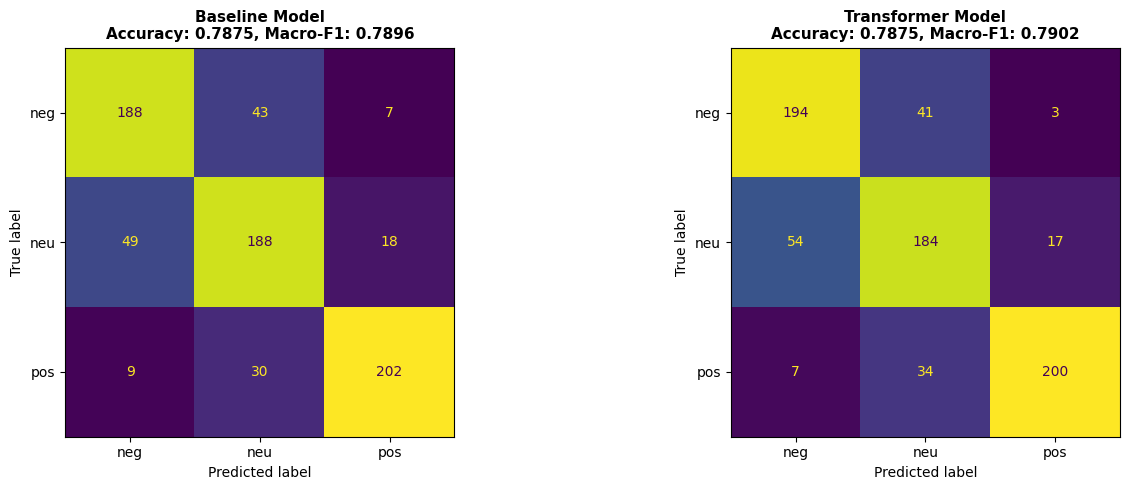


SIDE-BY-SIDE MODEL COMPARISON


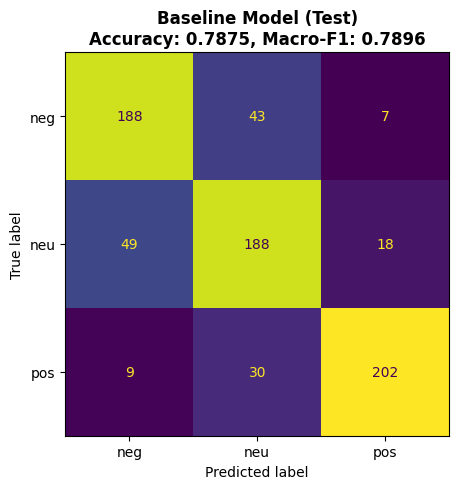

BASELINE MODEL - TEST SET EVALUATION
Accuracy: 0.7875
Macro-F1: 0.7896
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.79      0.78       238
     neutral       0.72      0.74      0.73       255
    positive       0.89      0.84      0.86       241

    accuracy                           0.79       734
   macro avg       0.79      0.79      0.79       734
weighted avg       0.79      0.79      0.79       734




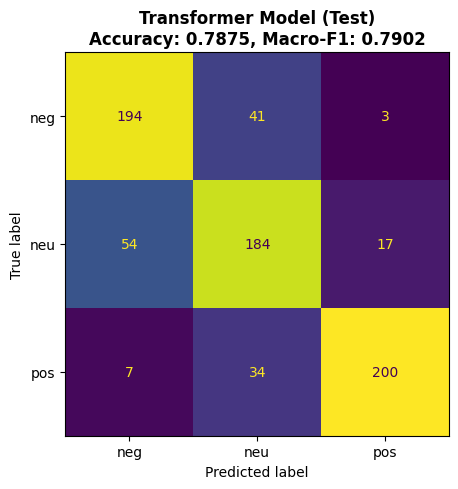

TRANSFORMER MODEL - TEST SET EVALUATION
Accuracy: 0.7875
Macro-F1: 0.7902
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.82      0.79       238
     neutral       0.71      0.72      0.72       255
    positive       0.91      0.83      0.87       241

    accuracy                           0.79       734
   macro avg       0.79      0.79      0.79       734
weighted avg       0.79      0.79      0.79       734




,model,accuracy,f1_macro
1,transformer_best,0.787466,0.790217
0,baseline_best,0.787466,0.789597


In [25]:

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from pathlib import Path

outdir = Path('exports')
outdir.mkdir(exist_ok=True)
rows = []

# Create side-by-side comparison figure
if os.path.exists('baseline_predictions_test.csv') and os.path.exists('transformer_predictions_test.csv'):
    fig_comp, axes_comp = plt.subplots(1, 2, figsize=(14, 5))

    # Baseline
    dfb = pd.read_csv('baseline_predictions_test.csv')
    y_true_b = dfb['gold'].values; y_pred_b = dfb['pred'].values
    acc_b = accuracy_score(y_true_b, y_pred_b); f1m_b = f1_score(y_true_b, y_pred_b, average='macro')
    cm_b = confusion_matrix(y_true_b, y_pred_b, labels=[0,1,2])
    ConfusionMatrixDisplay(cm_b, display_labels=['neg','neu','pos']).plot(ax=axes_comp[0], colorbar=False)
    axes_comp[0].set_title(f'Baseline Model\nAccuracy: {acc_b:.4f}, Macro-F1: {f1m_b:.4f}', fontsize=11, fontweight='bold')

    # Transformer
    dft = pd.read_csv('transformer_predictions_test.csv')
    y_true_t = dft['gold'].values; y_pred_t = dft['pred'].values
    acc_t = accuracy_score(y_true_t, y_pred_t); f1m_t = f1_score(y_true_t, y_pred_t, average='macro')
    cm_t = confusion_matrix(y_true_t, y_pred_t, labels=[0,1,2])
    ConfusionMatrixDisplay(cm_t, display_labels=['neg','neu','pos']).plot(ax=axes_comp[1], colorbar=False)
    axes_comp[1].set_title(f'Transformer Model\nAccuracy: {acc_t:.4f}, Macro-F1: {f1m_t:.4f}', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(outdir/'CM_comparison_test.png', dpi=150)
    plt.show()
    print("\n" + "="*70)
    print("SIDE-BY-SIDE MODEL COMPARISON")
    print("="*70)

# Baseline
if os.path.exists('baseline_predictions_test.csv'):
    dfb = pd.read_csv('baseline_predictions_test.csv')
    y_true = dfb['gold'].values
    y_pred = dfb['pred'].values
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    rows.append({'model':'baseline_best', 'accuracy':acc, 'f1_macro':f1m})
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

    # Display in notebook
    fig_b, ax_b = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(ax=ax_b, colorbar=False)
    ax_b.set_title(f'Baseline Model (Test)\nAccuracy: {acc:.4f}, Macro-F1: {f1m:.4f}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(outdir/'CM_baseline_test.png', dpi=150)
    plt.show()

    print("="*70)
    print("BASELINE MODEL - TEST SET EVALUATION")
    print("="*70)
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=[0,1,2], target_names=['negative','neutral','positive']))
    print()

# Transformer
if os.path.exists('transformer_predictions_test.csv'):
    dft = pd.read_csv('transformer_predictions_test.csv')
    y_true = dft['gold'].values
    y_pred = dft['pred'].values
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    rows.append({'model':'transformer_best', 'accuracy':acc, 'f1_macro':f1m})
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

    # Display in notebook
    fig_t, ax_t = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(ax=ax_t, colorbar=False)
    ax_t.set_title(f'Transformer Model (Test)\nAccuracy: {acc:.4f}, Macro-F1: {f1m:.4f}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(outdir/'CM_transformer_test.png', dpi=150)
    plt.show()

    print("="*70)
    print("TRANSFORMER MODEL - TEST SET EVALUATION")
    print("="*70)
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=[0,1,2], target_names=['negative','neutral','positive']))
    print()

if rows:
    cmp = pd.DataFrame(rows).sort_values('f1_macro', ascending=False)
    cmp.to_csv(outdir/'Sentiment_Comparison.csv', index=False)
    try:
        cmp.to_excel(outdir/'Sentiment_Comparison.xlsx', index=False)
    except Exception:
        pass
    display(cmp)
else:
    print('No predictions found yet. Run cells above first.')

**`Purpose`**

This block consolidates the experiment ledger into export files that support grading and documentation. It merges local runs with any team template, sorts them by macro-F1, and writes CSV and spreadsheet versions, along with summary tables for “best by model,” “runs per model,” and the “top ten by macro-F1.”

**`Input`**

The inputs are runs_log.csv produced by previous training cells and an optional Experiment_Log_Template.xlsx if a group sheet is in use. The code aligns column names and merges tables so that both personal and team entries appear together.

**`Output`**

The block writes exports/Experiment_Runs_All.csv and .xlsx, as well as Best_by_Model, Runs_per_Model, and Top10_by_F1 files in both CSV and Excel formats when possible. A short message confirms export success. These files are suitable for inclusion as appendix tables and as sources for figures.

**`Details`**

The merged table is sorted by macro-F1 to surface the strongest runs first. A “best by model” table keeps only the top row per backbone to support quick comparisons in the Results section. A “runs per model” count shows coverage across backbones. A “top ten by F1” slice provides a quick list of leading configurations for screenshots. The exports follow stable column names so that downstream formatting or conditional coloring in spreadsheets is straightforward.

**`Line-by-line Description`**

`from pathlib import Path` prepares folder handling, and `outdir = Path('exports'); outdir.mkdir(exist_ok=True)` ensures the output directory exists.

`df_runs = pd.read_csv('runs_log.csv') if os.path.exists('runs_log.csv') else pd.DataFrame()` loads the personal ledger or falls back to an empty table.

The branch that checks `Experiment_Log_Template.xlsx` merges a team sheet when available, aligns columns, and creates a unified table.

`if not df_all.empty:` guards the export steps so that the code only writes files when there is data to save.

`df_all = df_all.sort_values('f1_macro', ascending=False)` places the highest macro-F1 at the top.

`df_all.to_csv(...)` and `df_all.to_excel(...)` write consolidated logs for easy sharing.

The next group builds `best_by_model` by keeping the top row per backbone, writes it out, and creates a `rpm` count of runs per model.

In [26]:
from pathlib import Path
outdir = Path('exports'); outdir.mkdir(exist_ok=True)

if os.path.exists('runs_log.csv'):
    try:
        df_runs = pd.read_csv('runs_log.csv')
    except Exception as exc:
        print(f"Primary CSV read failed ({exc}); retrying with python engine and on_bad_lines='skip'.")
        df_runs = pd.read_csv('runs_log.csv', engine='python', on_bad_lines='skip')
else:
    df_runs = pd.DataFrame()
if os.path.exists('Experiment_Log_Template.xlsx'):
    df_team = pd.read_excel('Experiment_Log_Template.xlsx')
    for d in (df_runs, df_team):
        d.columns = [str(c).strip().lower() for c in d.columns]
    all_cols = sorted(set(df_runs.columns) | set(df_team.columns))
    df_runs = df_runs.reindex(columns=all_cols)
    df_team = df_team.reindex(columns=all_cols)
    df_all = pd.concat([df_team, df_runs], ignore_index=True).drop_duplicates()
else:
    df_all = df_runs

if not df_all.empty:
    if 'f1_macro' in df_all.columns:
        df_all = df_all.sort_values(by='f1_macro', ascending=False)
    df_all.to_csv(outdir/'Experiment_Runs_All.csv', index=False)
    try:
        df_all.to_excel(outdir/'Experiment_Runs_All.xlsx', index=False)
    except Exception as e:
        print("Excel export error:", e)

    if 'model' in df_all.columns and 'f1_macro' in df_all.columns:
        best_by_model = df_all.sort_values('f1_macro', ascending=False).drop_duplicates(subset=['model'])
        best_by_model.to_csv(outdir/'Best_by_Model.csv', index=False)
        best_by_model.to_excel(outdir/'Best_by_Model.xlsx', index=False)

        rpm = df_all['model'].value_counts().rename_axis('model').reset_index(name='runs')
        rpm.to_csv(outdir/'Runs_per_Model.csv', index=False)
        rpm.to_excel(outdir/'Runs_per_Model.xlsx', index=False)

    if 'f1_macro' in df_all.columns:
        top10 = df_all.head(10)
        top10.to_csv(outdir/'Top10_by_F1.csv', index=False)
        top10.to_excel(outdir/'Top10_by_F1.xlsx', index=False)
    print("Exported logs to exports/.")
else:
    print("No logs found yet.")


Primary CSV read failed (Error tokenizing data. C error: Expected 15 fields in line 4, saw 18
); retrying with python engine and on_bad_lines='skip'.
Exported logs to exports/.
